# Introdução

A Fórmula 1 é um esporte definido tanto pela engenharia de precisão quanto pela sua natureza estocástica. Prever o resultado exato de uma corrida é um desafio complexo devido a variáveis como clima, estratégias de pit stop e falhas mecânicas.

Este notebook documenta o desenvolvimento de um pipeline de Machine Learning focado em prever a **faixa de classificação final** dos pilotos (Vencedor, Pódio, Zona de Pontuação ou Fora dos Pontos). Ao transformar o problema de uma regressão linear pura para uma **classificação multiclasse**, buscamos mitigar o ruído inerente aos dados e focar em resultados estrategicamente relevantes.

# Definição do problema

O objetivo deste estudo é prever a classificação final de um piloto com base em dados pré-corrida. Embora a posição final seja uma variável contínua (1º ao 20º), a natureza estratégica da Fórmula 1 sugere que a **regressão linear** pura não captura o valor real dos resultados (ex: a diferença entre 1º e 2º é muito mais significativa do que entre 15º e 16º).

Portanto, formulamos o problema como uma **Classificação Multiclasse**.

### Formalização
Dado um vetor de entrada $x_i$ contendo características do piloto, construtor e circuito, buscamos mapear uma função $f(x_i) \rightarrow y_i$, onde $y_i$ pertence a uma das quatro classes de performance ("Tiers"):

* **Winner:** Posição 1 (Vitória).
* **Podium:** Posições 2 e 3 (Pódio, mas sem vitória).
* **Points:** Posições 4 a 10 (Zona de pontuação).
* **No_Points:** Posições 11 ou superior (Fora dos pontos).

$$
y_i =
\begin{cases}
\textbf{Winner} & \text{se } Pos = 1 \\
\textbf{Podium} & \text{se } Pos \in \{2, 3\} \\
\textbf{Points} & \text{se } Pos \in \{4, \dots, 10\} \\
\textbf{No Points} & \text{se } Pos > 10
\end{cases}
$$

### Escopo e Restrições
1. **Era Híbrida:** O dataset é restrito a corridas a partir de 2014 para garantir consistência nas regras de engenharia e pontuação.
2. **Filtro de DNF:** O foco do modelo é performance pura. Pilotos que não terminaram a corrida (DNF - *Did Not Finish*) devido a falhas mecânicas ou acidentes foram excluídos do conjunto de treinamento e validação.
3. **Desbalanceamento:** As classes são naturalmente desbalanceadas (apenas 1 Vencedor vs. ~10 Não Pontuadores), o que exigirá estratégias de métricas balanceadas na avaliação.

# Descrição do conjunto de dados

### Fonte e Escopo
Os dados utilizados neste projeto foram extraídos da **Ergast Developer API**, a base de dados histórica de referência para a Fórmula 1.

Para garantir a consistência das características veiculares (motores V6 Turbo-Híbridos) e das regras de pontuação, o dataset foi restrito à **Era Híbrida**, compreendendo todos os Grandes Prêmios realizados a partir da temporada de **2014**.

### Estrutura e Agregação
O *feature matrix* final foi construído através da junção (merge) de várias tabelas relacionais, permitindo cruzar dados de performance com dados de contexto, abaixo são listadas algumas delas:

* `results.csv`: Fonte da variável alvo (`positionOrder`), posições de grid e pontos.
* `qualifying.csv`: Tempos de volta (Q1, Q2, Q3), utilizados para calcular a feature crítica `gap_to_p10` (diferença de tempo para a zona de corte).
* `races.csv` & `circuits.csv`: Metadados temporais e geográficos, essenciais para a clusterização de pistas (ex: altitude, tipo de circuito).
* `status.csv`: Utilizado para identificar e remover pilotos que não terminaram a corrida (DNF) por motivos alheios à performance (acidentes ou falhas mecânicas).

### Pipeline de Pré-processamento
Para preparar os dados para os algoritmos de Machine Learning, aplicamos o seguinte pipeline:

1.  **Conversão de Tempo:** Transformação de strings de tempo (ex: "1:24.500") para valores numéricos contínuos (segundos).
2.  **Imputação Lógica:** Valores ausentes na qualificação foram preenchidos com penalidades calculadas (tempo máximo da sessão + delta), representando pilotos que não marcaram tempo, sem descartar a amostra.
3.  **Prevenção de Data Leakage (Vazamento de Dados):** O dataset foi estritamente ordenado cronologicamente. Todas as features históricas (como *Driver Track Affinity* e *Constructor Strength*) foram geradas usando janelas deslizantes (`rolling`) e funções de atraso (`shift`), garantindo que o modelo utilize apenas informações disponíveis **antes** da largada.

# Metodologia

Para abordar o problema de classificação multiclasse, implementamos um pipeline de Machine Learning composto por três etapas principais: Engenharia de Atributos Avançada, Modelagem com Ensemble e Avaliação Rigorosa.

### 1. Engenharia de Atributos (Feature Engineering)
Dada a alta dimensionalidade e o ruído dos dados brutos, a telemetria pura é insuficiente. Introduzimos variáveis derivadas para capturar nuances de performance:

* **Qualifying Gap to P10 ($\Delta t_{P10}$):** A posição de largada isolada não captura a densidade do pelotão intermediário. Calculamos a diferença de tempo entre a melhor volta do piloto e o tempo de corte do 10º colocado.
    * *Intuição:* Um gap negativo indica performance de elite; um gap pequeno positivo sugere potencial de pontuar.
* **Teammate Performance Delta ($\delta_{team}$):** Para isolar a habilidade do piloto da qualidade do carro, comparamos a posição de largada do piloto com a média da equipe.
    * *Intuição:* Valores negativos indicam que o piloto está "superando" o equipamento.
* **Circuit Clustering:** Agrupamento não-supervisionado das pistas (ex: alta velocidade vs. rua) para fornecer contexto físico ao modelo.

### 2. Algoritmos de Machine Learning
Utilizamos duas técnicas distintas de *ensemble learning* para maximizar a robustez:

* **Random Forest (Bagging):** Escolhido pela sua resistência ao *overfitting* e capacidade de capturar interações não-lineares.
* **XGBoost (Boosting):** Configurado com a função objetivo `softprob` e pesos de classe, focado em corrigir erros sequenciais e lidar com o desbalanceamento das classes minoritárias (Vencedores).

### 3. Estratégia de Avaliação
O conjunto de dados foi dividido em treino (75%) e teste (25%) utilizando amostragem estratificada para manter a distribuição das classes. A performance é avaliada através de:
* **Acurácia Global:** Taxa de acerto geral.
* **Acurácia Balanceada:** Média da sensibilidade por classe (crucial para a classe *Winner*).
* **Matriz de Confusão:** Para visualizar erros específicos entre classes adjacentes (ex: confundir Pódio com Pontos).

# Desenvolvimento do projeto

# Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.utils.class_weight import compute_sample_weight

import scipy.cluster.hierarchy as sch

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

DIR_DATA = os.getcwd() + '/data/'

# Carregando Datasets
Importando os datasets e visualizando a estrutura dos dados

In [2]:
df_circuits = pd.read_csv(DIR_DATA + 'circuits.csv', sep=',', na_values='\\N')
print("Circuits Dataset")
print(f"Columns: {list(df_circuits.columns)}")
print(f"Shape: {df_circuits.shape}")
df_circuits.head()

Circuits Dataset
Columns: ['circuitId', 'circuitRef', 'name', 'location', 'country', 'lat', 'lng', 'alt', 'url']
Shape: (77, 9)


,circuitId,circuitRef,name,location,country,lat,lng,alt,url
0,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
1,2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800,18,http://en.wikipedia.org/wiki/Sepang_Internatio...
2,3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060,7,http://en.wikipedia.org/wiki/Bahrain_Internati...
3,4,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111,109,http://en.wikipedia.org/wiki/Circuit_de_Barcel...
4,5,istanbul,Istanbul Park,Istanbul,Turkey,40.95170,29.40500,130,http://en.wikipedia.org/wiki/Istanbul_Park


In [3]:
df_constructors_results = pd.read_csv(DIR_DATA + 'constructor_results.csv', sep=',', na_values='\\N')
print("Constructors Results Dataset")
print(f"Columns: {list(df_constructors_results.columns)}")
print(f"Shape: {df_constructors_results.shape}")
df_constructors_results.head()

Constructors Results Dataset
Columns: ['constructorResultsId', 'raceId', 'constructorId', 'points', 'status']
Shape: (12625, 5)


,constructorResultsId,raceId,constructorId,points,status
0,1,18,1,14.0,NaN
1,2,18,2,8.0,NaN
2,3,18,3,9.0,NaN
3,4,18,4,5.0,NaN
4,5,18,5,2.0,NaN


In [4]:
df_constructors_standings = pd.read_csv(DIR_DATA + 'constructor_standings.csv', sep=',', na_values='\\N')
print("Constructors Standings Dataset")
print(f"Columns : {list(df_constructors_standings.columns)}")
print(f"Shape: {df_constructors_standings.shape}")
df_constructors_standings.head()

Constructors Standings Dataset
Columns : ['constructorStandingsId', 'raceId', 'constructorId', 'points', 'position', 'positionText', 'wins']
Shape: (13391, 7)


,constructorStandingsId,raceId,constructorId,points,position,positionText,wins
0,1,18,1,14.0,1,1,1
1,2,18,2,8.0,3,3,0
2,3,18,3,9.0,2,2,0
3,4,18,4,5.0,4,4,0
4,5,18,5,2.0,5,5,0


In [5]:
df_driver_standings = pd.read_csv(DIR_DATA + 'driver_standings.csv', sep=',', na_values='\\N')
print("Drivers Standings Dataset")
print(f"Columns : {list(df_driver_standings.columns)}")
print(f"Shape: {df_driver_standings.shape}")
df_driver_standings.head()

Drivers Standings Dataset
Columns : ['driverStandingsId', 'raceId', 'driverId', 'points', 'position', 'positionText', 'wins']
Shape: (34863, 7)


,driverStandingsId,raceId,driverId,points,position,positionText,wins
0,1,18,1,10.0,1,1,1
1,2,18,2,8.0,2,2,0
2,3,18,3,6.0,3,3,0
3,4,18,4,5.0,4,4,0
4,5,18,5,4.0,5,5,0


In [6]:
df_drivers = pd.read_csv(DIR_DATA + 'drivers.csv', sep=',', na_values='\\N')
print("Drivers Dataset")
print(f"Columns : {list(df_drivers.columns)}")
print(f"Shape: {df_drivers.shape}")
df_drivers.head()

Drivers Dataset
Columns : ['driverId', 'driverRef', 'number', 'code', 'forename', 'surname', 'dob', 'nationality', 'url']
Shape: (861, 9)


,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44.0,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,NaN,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6.0,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14.0,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,NaN,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [7]:
df_lap_times = pd.read_csv(DIR_DATA + 'lap_times.csv', sep=',', na_values='\\N')
print("Lap Times Dataset")
print(f"Columns : {list(df_lap_times.columns)}")
print(f"Shape: {df_lap_times.shape}")
df_lap_times.head()

Lap Times Dataset
Columns : ['raceId', 'driverId', 'lap', 'position', 'time', 'milliseconds']
Shape: (589081, 6)


,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342


In [8]:
df_pitstops = pd.read_csv(DIR_DATA + 'pit_stops.csv', sep=',', na_values='\\N')
print("PitStops Dataset")
print(f"Columns : {list(df_pitstops.columns)}")
print(f"Shape: {df_pitstops.shape}")
df_pitstops.head()

PitStops Dataset
Columns : ['raceId', 'driverId', 'stop', 'lap', 'time', 'duration', 'milliseconds']
Shape: (11371, 7)


,raceId,driverId,stop,lap,time,duration,milliseconds
0,841,153,1,1,17:05:23,26.898,26898
1,841,30,1,1,17:05:52,25.021,25021
2,841,17,1,11,17:20:48,23.426,23426
3,841,4,1,12,17:22:34,23.251,23251
4,841,13,1,13,17:24:10,23.842,23842


In [9]:
df_qualifying = pd.read_csv(DIR_DATA + 'qualifying.csv', sep=',', na_values='\\N')
print("Qualifying Dataset")
print(f"Columns : {list(df_qualifying.columns)}")
print(f"Shape: {df_qualifying.shape}")
df_qualifying.head()

Qualifying Dataset
Columns : ['qualifyId', 'raceId', 'driverId', 'constructorId', 'number', 'position', 'q1', 'q2', 'q3']
Shape: (10494, 9)


,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3
0,1,18,1,1,22,1,1:26.572,1:25.187,1:26.714
1,2,18,9,2,4,2,1:26.103,1:25.315,1:26.869
2,3,18,5,1,23,3,1:25.664,1:25.452,1:27.079
3,4,18,13,6,2,4,1:25.994,1:25.691,1:27.178
4,5,18,2,2,3,5,1:25.960,1:25.518,1:27.236


In [10]:
df_races = pd.read_csv(DIR_DATA + 'races.csv', sep=',', na_values='\\N')
print("Races Dataset")
print(f"Columns : {list(df_races.columns)}")
print(f"Shape: {df_races.shape}")
df_races.head()

Races Dataset
Columns : ['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time', 'url', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time']
Shape: (1125, 18)


,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_results = pd.read_csv(DIR_DATA + 'results.csv', sep=',', na_values='\\N')
print("Results Dataset")
print(f"Columns : {list(df_results.columns)}")
print(f"Shape: {df_results.shape}")
df_results.head()

Results Dataset
Columns : ['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid', 'position', 'positionText', 'positionOrder', 'points', 'laps', 'time', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'statusId']
Shape: (26759, 18)


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22.0,1,1.0,1,1,10.0,58,1:34:50.616,5690616.0,39.0,2.0,1:27.452,218.300,1
1,2,18,2,2,3.0,5,2.0,2,2,8.0,58,+5.478,5696094.0,41.0,3.0,1:27.739,217.586,1
2,3,18,3,3,7.0,7,3.0,3,3,6.0,58,+8.163,5698779.0,41.0,5.0,1:28.090,216.719,1
3,4,18,4,4,5.0,11,4.0,4,4,5.0,58,+17.181,5707797.0,58.0,7.0,1:28.603,215.464,1
4,5,18,5,1,23.0,3,5.0,5,5,4.0,58,+18.014,5708630.0,43.0,1.0,1:27.418,218.385,1


In [12]:
df_seasons = pd.read_csv(DIR_DATA + 'seasons.csv', sep=',', na_values='\\N')
print("Seasons Dataset")
print(f"Columns : {list(df_seasons.columns)}")
print(f"Shape: {df_seasons.shape}")
df_seasons.head()

Seasons Dataset
Columns : ['year', 'url']
Shape: (75, 2)


,year,url
0,2009,http://en.wikipedia.org/wiki/2009_Formula_One_...
1,2008,http://en.wikipedia.org/wiki/2008_Formula_One_...
2,2007,http://en.wikipedia.org/wiki/2007_Formula_One_...
3,2006,http://en.wikipedia.org/wiki/2006_Formula_One_...
4,2005,http://en.wikipedia.org/wiki/2005_Formula_One_...


In [13]:
df_sprint_results = pd.read_csv(DIR_DATA + 'sprint_results.csv', sep=',', na_values='\\N')
print("Sprints Result Dataset")
print(f"Columns : {list(df_sprint_results.columns)}")
print(f"Shape: {df_sprint_results.shape}")
df_sprint_results.head()

Sprints Result Dataset
Columns : ['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid', 'position', 'positionText', 'positionOrder', 'points', 'laps', 'time', 'milliseconds', 'fastestLap', 'fastestLapTime', 'statusId']
Shape: (360, 16)


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,fastestLapTime,statusId
0,1,1061,830,9,33,2,1.0,1,1,3,17,25:38.426,1538426.0,14.0,1:30.013,1
1,2,1061,1,131,44,1,2.0,2,2,2,17,+1.430,1539856.0,17.0,1:29.937,1
2,3,1061,822,131,77,3,3.0,3,3,1,17,+7.502,1545928.0,17.0,1:29.958,1
3,4,1061,844,6,16,4,4.0,4,4,0,17,+11.278,1549704.0,16.0,1:30.163,1
4,5,1061,846,1,4,6,5.0,5,5,0,17,+24.111,1562537.0,16.0,1:30.566,1


In [14]:
df_status = pd.read_csv(DIR_DATA + 'status.csv', sep=',', na_values='\\N')
print("Status Dataset")
print(f"Columns : {list(df_status.columns)}")
print(f"Shape: {df_status.shape}")
df_status.head()

Status Dataset
Columns : ['statusId', 'status']
Shape: (139, 2)


,statusId,status
0,1,Finished
1,2,Disqualified
2,3,Accident
3,4,Collision
4,5,Engine


In [15]:
df_constructors = pd.read_csv(DIR_DATA + 'constructors.csv', sep=',', na_values='\\N')
print("Constructors Dataset")
print(f"Columns : {list(df_constructors.columns)}")
print(f"Shape: {df_constructors.shape}")
df_constructors.head()

Constructors Dataset
Columns : ['constructorId', 'constructorRef', 'name', 'nationality', 'url']
Shape: (212, 5)


,constructorId,constructorRef,name,nationality,url
0,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
1,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber
2,3,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...
3,4,renault,Renault,French,http://en.wikipedia.org/wiki/Renault_in_Formul...
4,5,toro_rosso,Toro Rosso,Italian,http://en.wikipedia.org/wiki/Scuderia_Toro_Rosso


# Merge datasets
Unificando as diversas fontes de dados relacionais (Resultados, Corridas, Pilotos, Construtores, Circuitos e Qualificação) em um único DataFrame.

O objetivo é enriquecer a tabela de resultados com o contexto completo do evento, incluindo características da pista, desempenho no treino classificatório e situação do campeonato no momento da corrida. Também é feita a conversão inicial de tipos numéricos essenciais.

In [16]:
# Juntando Resultados com Corridas (para pegar ano e circuito)
df = df_results.merge(df_races[['raceId', 'year', 'name', 'date', 'circuitId', 'round']], on='raceId', how='left')

# Juntando com Pilotos (nome, nacionalidade)
df = df.merge(df_drivers[['driverId', 'driverRef', 'nationality', 'dob']], on='driverId', how='left')

# Juntando com Construtores (equipes)
df = df.merge(df_constructors[['constructorId', 'constructorRef', 'nationality']], on='constructorId', how='left', suffixes=('_driver', '_team'))

# Juntando com Status (causa do fim da corrida)
df = df.merge(df_status[['statusId', 'status']], on='statusId', how='left')

# Juntando com Circuitos (Latitude, Longitude, Altitude)
# Renomeando 'name' para 'circuit_name' para não conflitar com o nome da corrida
df = df.merge(df_circuits[['circuitId', 'name', 'location', 'country', 'lat', 'lng', 'alt']], on='circuitId', how='left', suffixes=('', '_circuit'))
df.rename(columns={'name_circuit': 'circuit_name'}, inplace=True)

# Juntando com Qualificação (Tempos de Q1, Q2, Q3)
# Trazendo apenas os tempos, porque 'position' (grid) já está em results
df = df.merge(df_qualifying[['raceId', 'driverId', 'q1', 'q2', 'q3']], on=['raceId', 'driverId'], how='left')

# Juntando com Standings (Pontuação do campeonato naquela corrida)
# Renomeando para evitar conflito com os pontos da corrida e posição de chegada
df = df.merge(df_driver_standings[['raceId', 'driverId', 'points', 'position', 'wins']], on=['raceId', 'driverId'], how='left', suffixes=('', '_season'))
df.rename(columns={'points_season': 'driver_points_season', 'position': 'driver_rank_season', 'wins': 'driver_wins_season'}, inplace=True)

# Limpeza Rápida
# Convertendo posição para numérico e substituindo o que não for numérico por NaN
df['positionOrder'] = pd.to_numeric(df['positionOrder'], errors='coerce')
df['grid'] = pd.to_numeric(df['grid'], errors='coerce')
df['points'] = pd.to_numeric(df['points'], errors='coerce')

print(f"Dataset consolidado, Shape: {df.shape}")
df.head()

Dataset consolidado, Shape: (26759, 41)


,resultId,raceId,driverId,constructorId,number,grid,driver_rank_season,positionText,positionOrder,points,...,country,lat,lng,alt,q1,q2,q3,driver_points_season,position_season,driver_wins_season
0,1,18,1,1,22.0,1,1.0,1,1,10.0,...,Australia,-37.8497,144.968,10,1:26.572,1:25.187,1:26.714,10.0,1.0,1.0
1,2,18,2,2,3.0,5,2.0,2,2,8.0,...,Australia,-37.8497,144.968,10,1:25.960,1:25.518,1:27.236,8.0,2.0,0.0
2,3,18,3,3,7.0,7,3.0,3,3,6.0,...,Australia,-37.8497,144.968,10,1:26.295,1:26.059,1:28.687,6.0,3.0,0.0
3,4,18,4,4,5.0,11,4.0,4,4,5.0,...,Australia,-37.8497,144.968,10,1:26.907,1:26.188,NaN,5.0,4.0,0.0
4,5,18,5,1,23.0,3,5.0,5,5,4.0,...,Australia,-37.8497,144.968,10,1:25.664,1:25.452,1:27.079,4.0,5.0,0.0


In [17]:
df.columns

Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',
       'driver_rank_season', 'positionText', 'positionOrder', 'points', 'laps',
       'time', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'year', 'name', 'date', 'circuitId',
       'round', 'driverRef', 'nationality_driver', 'dob', 'constructorRef',
       'nationality_team', 'status', 'circuit_name', 'location', 'country',
       'lat', 'lng', 'alt', 'q1', 'q2', 'q3', 'driver_points_season',
       'position_season', 'driver_wins_season'],
      dtype='str')

# Análise Exploratória dos Dados

## Pilotos com maior número de vitórias
Identificando os pilotos dominantes no conjunto de dados. Com a análise é possível identificar que um pequeno grupo de pilotos (ex: Hamilton, Verstappen, Vettel) concentra a grande maioria das vitórias.

Este padrão evidencia o **desbalanceamento de classes** que o modelo precisará enfrentar: prever o vencedor é estatisticamente mais difícil do que prever posições intermediárias devido à escassez de exemplos positivos variados.

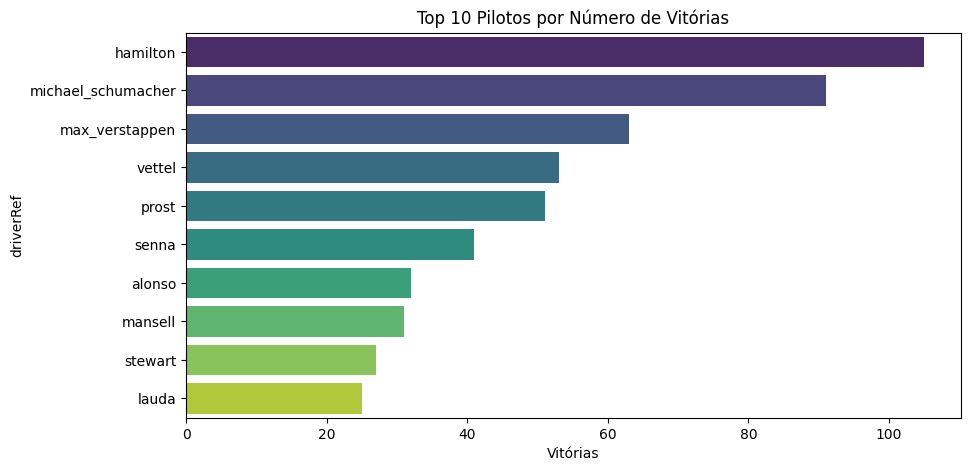

In [18]:
# Top 10 Pilotos com mais vitórias na base de dados
wins = df[df['positionOrder'] == 1].groupby('driverRef')['year'].count().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=wins.values, y=wins.index, palette='viridis')
plt.title('Top 10 Pilotos por Número de Vitórias')
plt.xlabel('Vitórias')
plt.show()

## Pilotos por nacionalidade
Levantamento demográfico dos pilotos que competiram na Fórmula 1. Ao isolar os registros únicos de cada competidor, é possível observar a representatividade por país de origem.

O gráfico destaca as 15 nacionalidades mais frequentes, permitindo observar a concentração histórica do esporte em países europeus e a predominância de nações tradicionais do automobilismo no grid.

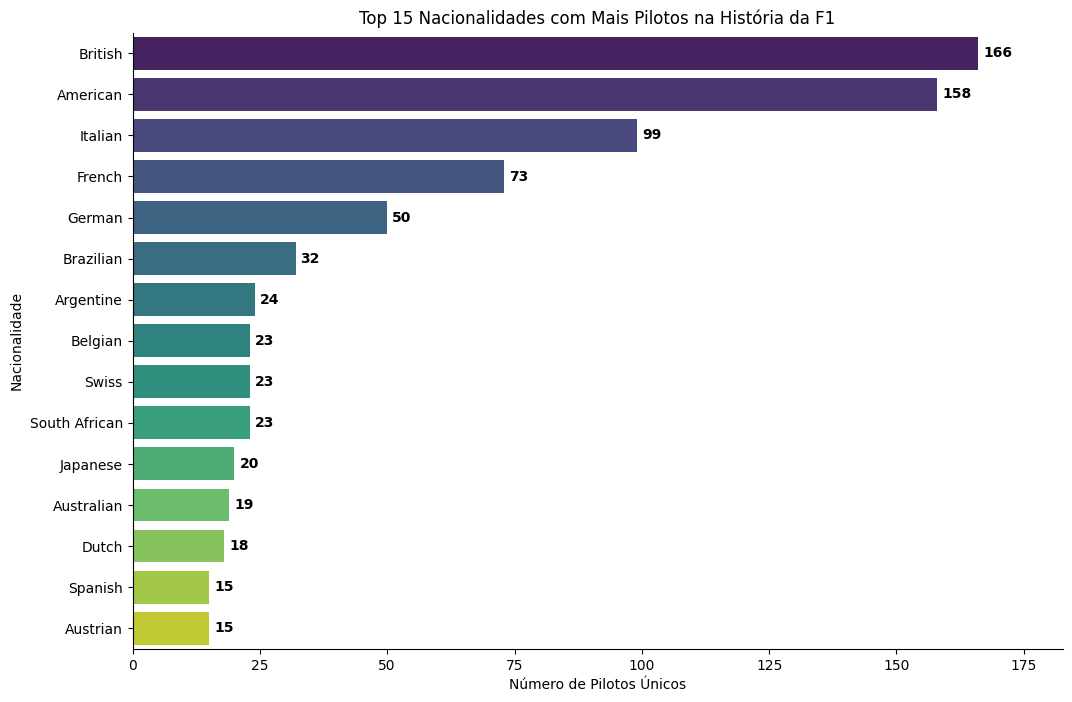

In [19]:
# Isolando pilotos únicos
unique_drivers = df[['driverId', 'nationality_driver']].drop_duplicates()

nationality_counts = unique_drivers['nationality_driver'].value_counts().head(15)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=nationality_counts.values, y=nationality_counts.index, palette='viridis')
plt.title('Top 15 Nacionalidades com Mais Pilotos na História da F1')
plt.xlabel('Número de Pilotos Únicos')
plt.ylabel('Nacionalidade')

for i, v in enumerate(nationality_counts.values):
    ax.text(v + 1, i, str(v), color='black', va='center', fontweight='bold')

plt.xlim(0, nationality_counts.max() * 1.1)
sns.despine()
plt.show()

## Equipes com maior número de vitórias
A análise quantifica o domínio histórico das equipes na Fórmula 1. O gráfico exibe os 10 construtores com maior número de vitórias acumuladas, evidenciando a forte correlação entre a equipe e o sucesso na pista.

Esta disparidade de performance justifica a inclusão de variáveis relacionadas à "força da equipe" (Constructor Strength) no modelo preditivo, visto que o equipamento é frequentemente um fator determinante para a vitória.

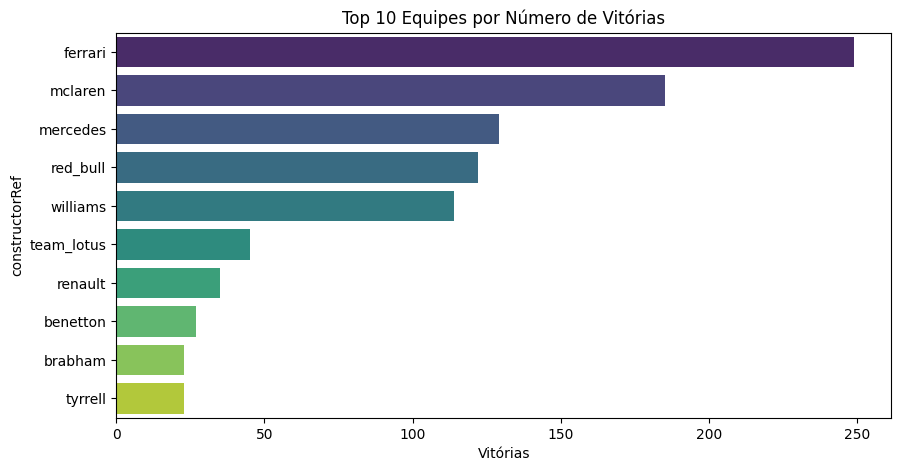

In [20]:
# Top 10 Equipes com mais vitórias na base de dados
wins = df[df['positionOrder'] == 1].groupby('constructorRef')['year'].count().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=wins.values, y=wins.index, palette='viridis')
plt.title('Top 10 Equipes por Número de Vitórias')
plt.xlabel('Vitórias')
plt.show()

## Correlação: Grid vs Posição Final
A ideia é investigar a relação direta entre o desempenho na qualificação (`grid`) e a classificação final na corrida (`positionOrder`).

Ao filtrar abandonos e focar apenas nos pilotos que completaram a prova, o gráfico de dispersão com regressão linear visualiza a tendência de conversão da posição de largada. O coeficiente de **Correlação de Spearman** é calculado para quantificar estatisticamente a força dessa associação, confirmando a importância do Grid como variável preditora fundamental.

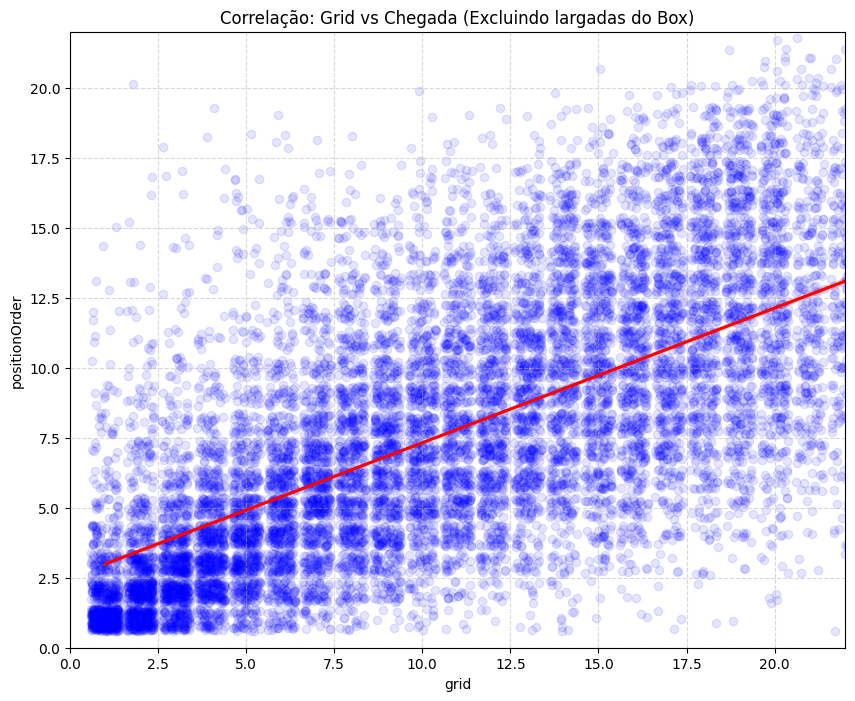

Correlação de Spearman: 0.71


In [21]:
# Filtrar status (Terminou ou +Voltas)
finished_races = df[(df['status'].str.contains('Finished')) | (df['status'].str.contains('\+'))].copy()
finished_races = finished_races[finished_races['grid'] > 0] 

plt.figure(figsize=(10, 8))
sns.regplot(data=finished_races, x='grid', y='positionOrder', 
            x_jitter=0.4, y_jitter=0.4,
            scatter_kws={'alpha': 0.1, 'color': 'blue'}, 
            line_kws={'color': 'red'})

plt.title('Correlação: Grid vs Chegada (Excluindo largadas do Box)')
plt.xlim(0, 22)
plt.ylim(0, 22)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

corr = finished_races[['grid', 'positionOrder']].corr(method='spearman').iloc[0,1]
print(f"Correlação de Spearman: {corr:.2f}")

## Análise de Confiabilidade (Quebras Mecânicas)
A confiabilidade dos carros é um fator crítico na Fórmula 1, frequentemente decidindo campeonatos. Aqui, é mapeado e quantificado os abandonos causados exclusivamente por problemas técnicos (ex: falha de motor, câmbio, hidráulica), excluindo acidentes de pista.

O filtro temporal restringe a análise à era moderna (pós-2010) para refletir os padrões de engenharia atuais. O gráfico resultante expõe quais construtores apresentaram historicamente maior fragilidade mecânica.

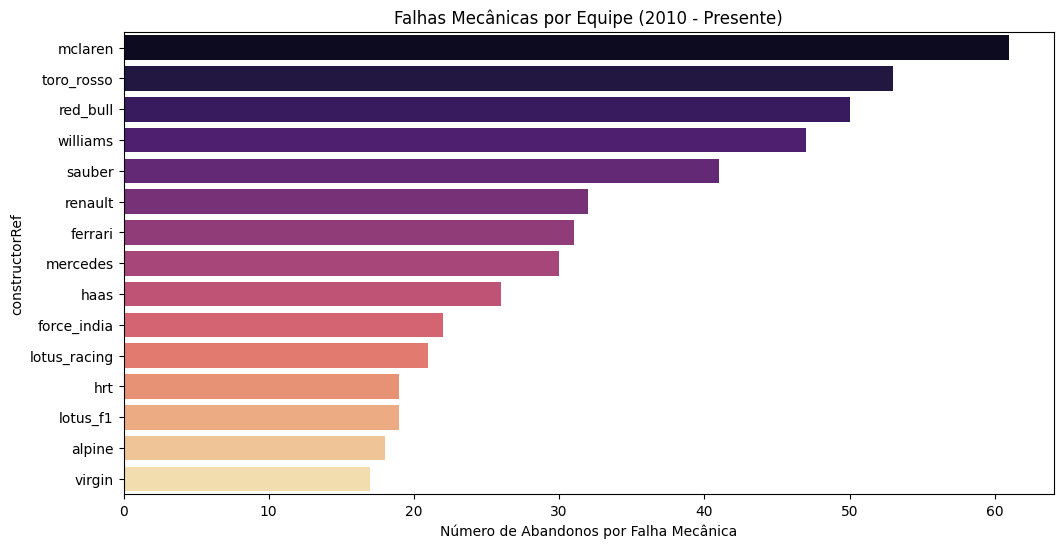

In [22]:
# Definir o que é falha mecânica
mechanical_issues = [
 'Engine',
 'Transmission',
 'Clutch',
 'Electrical',
 'Hydraulics',
 'Gearbox',
 'Radiator',
 'Suspension',
 'Brakes',
 'Overheating',
 'Mechanical',
 'Tyre',
 'Puncture',
 'Driveshaft',
 'Fuel pressure',
 'Water pressure',
 'Throttle',
 'Steering',
 'Technical',
 'Electronics',
 'Exhaust',
 'Oil leak',
 'Wheel rim',
 'Water leak',
 'Fuel pump',
 'Track rod',
 'Oil pressure',
 'Pneumatics',
 'Engine fire',
 'Tyre puncture',
 'Out of fuel',
 'Wheel nut',
 'Handling',
 'Fuel system',
 'Oil line',
 'Launch control',
 'Fuel',
 'Power loss',
 'Drivetrain',
 'Ignition',
 'Chassis',
 'Battery',
 'Stalled',
 'Halfshaft',
 'Crankshaft',
 'Alternator',
 'Differential',
 'Wheel bearing',
 'Vibrations',
 'Oil pump',
 'Fuel leak',
 'Injection',
 'Distributor',
 'Turbo',
 'CV joint',
 'Water pump',
 'Spark plugs',
 'Fuel pipe',
 'Oil pipe',
 'Axle',
 'Water pipe',
 'Magneto',
 'Supercharger',
 'Engine misfire',
 'ERS',
 'Power Unit',
 'Brake duct',
 'Cooling system',
 'Undertray'
]

recent_df = df[df['year'] >= 2010]
failures = recent_df[recent_df['status'].isin(mechanical_issues)]

# Contagem por equipe
team_failures = failures['constructorRef'].value_counts().head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x=team_failures.values, y=team_failures.index, palette='magma')
plt.title('Falhas Mecânicas por Equipe (2010 - Presente)')
plt.xlabel('Número de Abandonos por Falha Mecânica')
plt.show()

Contextualizando os dados de confiabilidade, a análise acompanha a trajetória das 5 equipes com o maior volume absoluto de falhas mecânicas.

O gráfico de linhas permite distinguir entre **problemas crônicos** (falhas consistentes ao longo dos anos) e **crises pontuais** (picos de quebras em temporadas específicas, geralmente associados a mudanças de regulamento ou fornecedor de motor). Identificar essas tendências é essencial para entender a estabilidade das equipes ao longo do tempo.

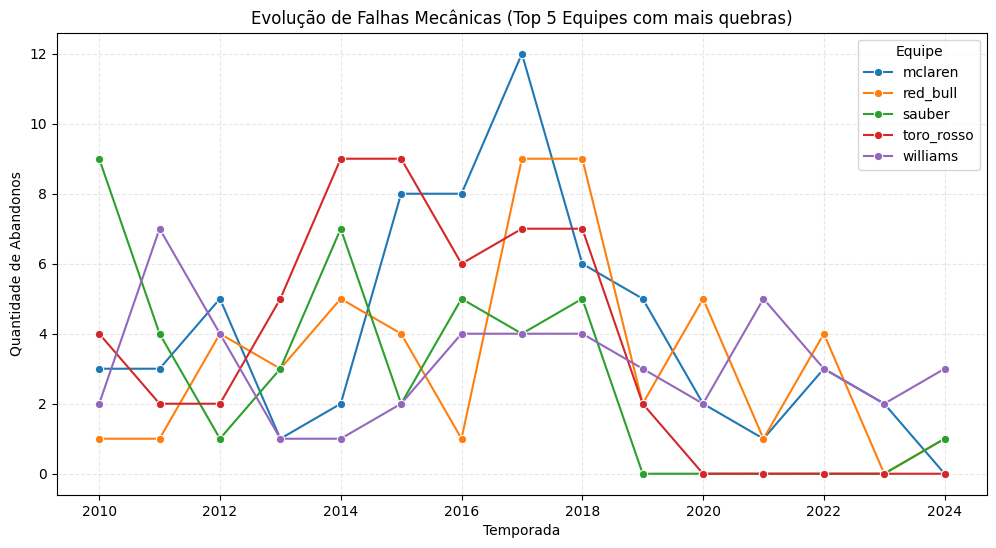

In [23]:
# 5 equipes com mais falhas no total
top_bad_teams = failures['constructorRef'].value_counts().head(5).index

failures_filtered = failures[failures['constructorRef'].isin(top_bad_teams)]

evolution = failures_filtered.pivot_table(index='year', columns='constructorRef', aggfunc='size', fill_value=0)

plt.figure(figsize=(12, 6))
sns.lineplot(data=evolution, dashes=False, marker='o')

plt.title('Evolução de Falhas Mecânicas (Top 5 Equipes com mais quebras)')
plt.ylabel('Quantidade de Abandonos')
plt.xlabel('Temporada')
plt.legend(title='Equipe')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

Aqui a visualização expande a análise para toda a história da Fórmula 1, traçando o volume absoluto de falhas mecânicas por temporada desde o campeonato inaugural.

O gráfico de linha permite observar as tendências macroscópicas da engenharia automotiva, contrastando eras de alta taxa de quebra (comuns nas décadas de 70 e 80) com a crescente confiabilidade na era moderna.

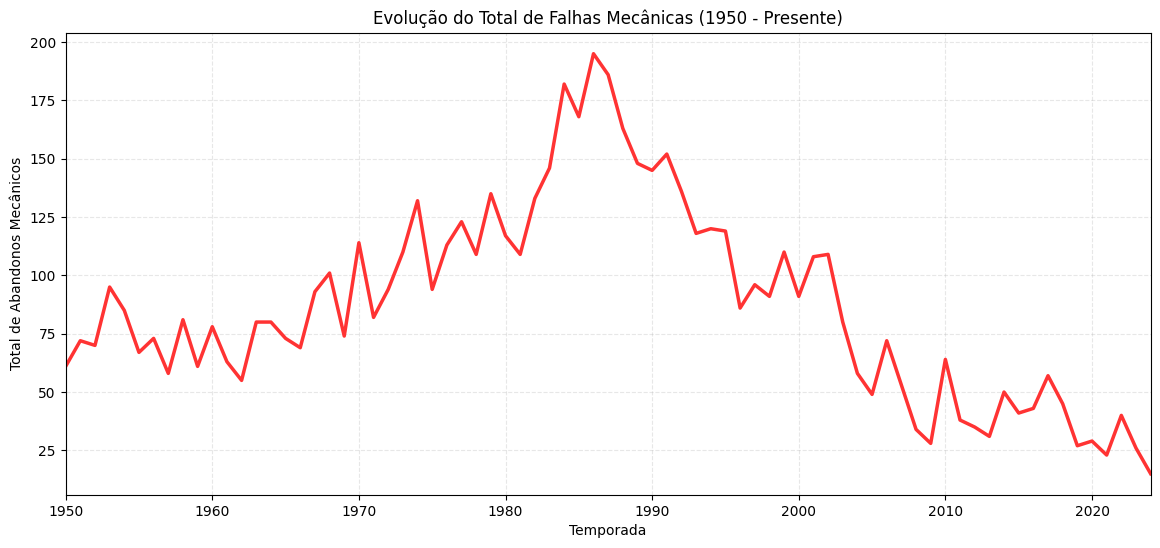

In [24]:
# Contar falhas por ano em todo o histórico
failures_history = df[df['status'].isin(mechanical_issues)].groupby('year').size()

plt.figure(figsize=(14, 6))

sns.lineplot(x=failures_history.index, y=failures_history.values, 
             color='#FF3333', linewidth=2.5)

plt.title('Evolução do Total de Falhas Mecânicas (1950 - Presente)')
plt.ylabel('Total de Abandonos Mecânicos')
plt.xlabel('Temporada')

plt.grid(True, linestyle='--', alpha=0.3)
plt.xlim(failures_history.index.min(), failures_history.index.max())
plt.show()

## Idade vs Performance
Visualizando a relação entre a maturidade do piloto e seu rendimento nas pistas. É calculada a idade exata do competidor no momento de cada largada e correlacionada com a média de pontos obtidos.

O recorte temporal (dados pós-2000) foi aplicado para mitigar as distorções causadas pelas mudanças nos sistemas de pontuação das décadas anteriores. O gráfico resultante permite identificar a idade dos pilotos que tem melhores resultados.

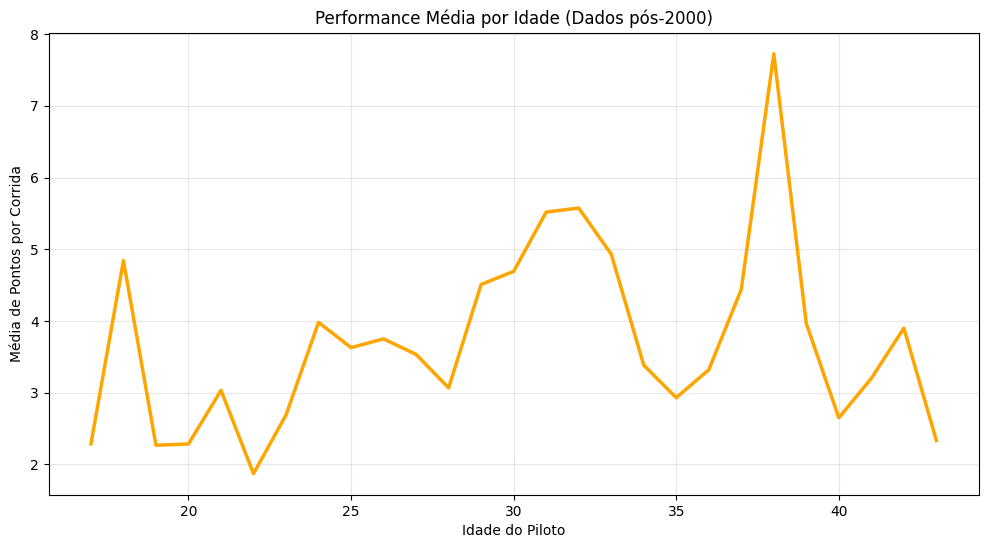

In [25]:
# Converter para datetime
df['dob'] = pd.to_datetime(df['dob'])
df['date'] = pd.to_datetime(df['date'])

# Calcular idade em anos
df['driver_age'] = (df['date'] - df['dob']).dt.days / 365.25

# Filtrar era moderna pós 2000 devido alterações nas pontuações
age_performance = df[df['year'] >= 2000].groupby(df['driver_age'].astype(int))['points'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=age_performance.index, y=age_performance.values, color='orange', linewidth=2.5)
plt.title('Performance Média por Idade (Dados pós-2000)')
plt.xlabel('Idade do Piloto')
plt.ylabel('Média de Pontos por Corrida')
plt.grid(True, alpha=0.3)
plt.show()

## Distribuição de Tempos de Pit Stop

A execução nos boxes é um diferencial competitivo crucial. Aqui é avaliada a performance das cinco principais equipes através da distribuição de seus tempos totais de pit stop.

Para garantir uma comparação justa da operação padrão, os dados foram filtrados para o intervalo entre **18s e 35s**, excluindo anomalias como reparos mecânicos extensos ou penalidades. O uso do *Violin Plot* permite visualizar simultaneamente a mediana e a largura da distribuição, revelando qual equipe combina melhor velocidade e estabilidade.

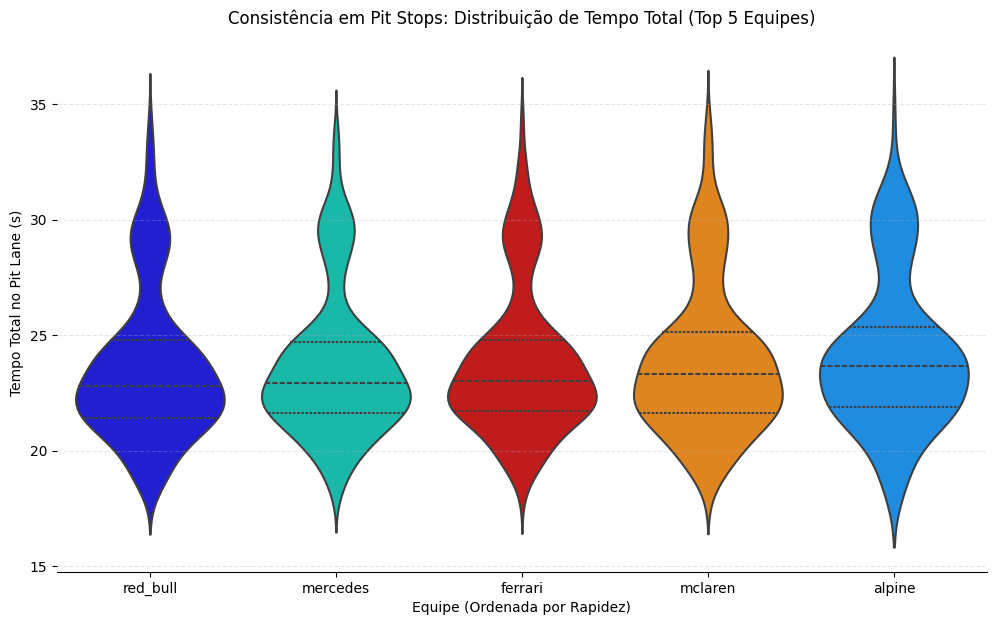

In [26]:
pits_merged = df_pitstops.merge(df[['raceId', 'driverId', 'constructorRef']], 
                                on=['raceId', 'driverId'], 
                                how='inner')

# Converter milissegundos para segundos
pits_merged['seconds'] = pits_merged['milliseconds'] / 1000

# Pit Stops normais (entre 18s e 35s) para remover erros de dados ou reparos longos
clean_pits = pits_merged[(pits_merged['seconds'] >= 18) & (pits_merged['seconds'] <= 35)]

# Filtrar apenas as Top 5 Equipes
top_teams = ['red_bull', 'mercedes', 'ferrari', 'mclaren', 'alpine']
clean_pits = clean_pits[clean_pits['constructorRef'].isin(top_teams)]

team_colors = {
    'red_bull': '#0600EF',  # Azul Escuro
    'mercedes': '#00D2BE',  # Turquesa/Prata
    'ferrari': '#DC0000',   # Vermelho
    'mclaren': '#FF8700',   # Laranja Papaya
    'alpine': '#0090FF'     # Azul Alpine
}

# Ordenar o dataframe pela mediana do tempo
order = clean_pits.groupby('constructorRef')['seconds'].median().sort_values().index

plt.figure(figsize=(12, 7))

# Violin Plot
sns.violinplot(data=clean_pits, x='constructorRef', y='seconds', 
               order=order, palette=team_colors, 
               inner='quartile', linewidth=1.5)

plt.title('Consistência em Pit Stops: Distribuição de Tempo Total (Top 5 Equipes)')
plt.xlabel('Equipe (Ordenada por Rapidez)')
plt.ylabel('Tempo Total no Pit Lane (s)')
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
sns.despine(left=True)

plt.show()

Essa visualização traça a trajetória de eficiência das equipes nos boxes ao longo das temporadas. A mediana anual é utilizada como métrica central para mitigar o impacto de *outliers* extremos (como reparos longos de danos).

O filtro aplicado (tempo < 50s) isola os procedimentos padrão de corrida. O gráfico permite observar tendências macroscópicas, como o impacto de mudanças no regulamento (ex: fim do reabastecimento, mudança nas dimensões dos pneus) e a constante busca pela redução do tempo total gasto no pit lane.

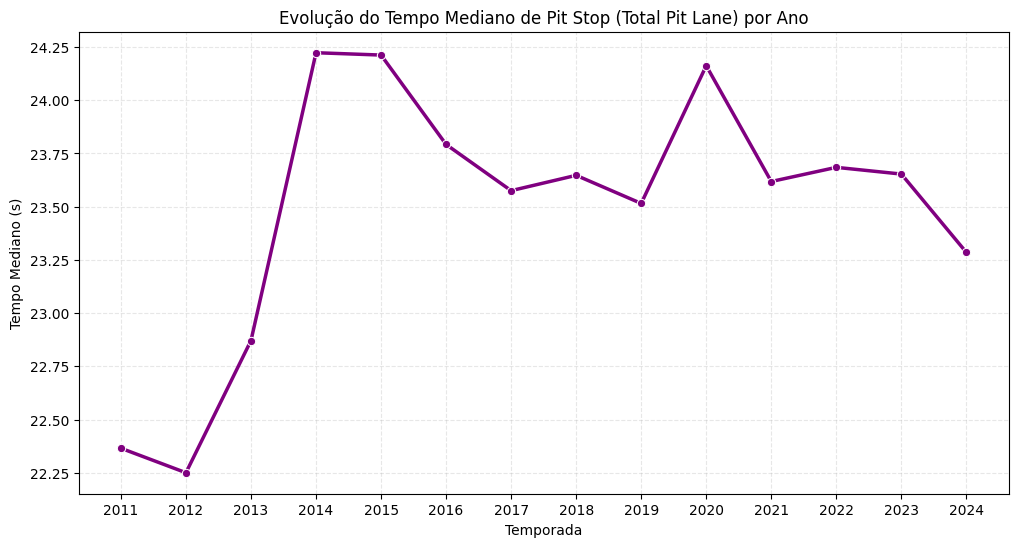

In [27]:
# Merge para associar os Pit Stops aos Anos
races_years = df[['raceId', 'year']].drop_duplicates()
pits_evolution = df_pitstops.merge(races_years, on='raceId', how='inner')

# Converter para segundos e filtrar anomalias
# Mantendo apenas paradas < 50s para focar em pit stops de corrida e excluir longos reparos mecânicos ou recolhimento do carro.
pits_evolution['seconds'] = pits_evolution['milliseconds'] / 1000
pits_clean = pits_evolution[pits_evolution['seconds'] < 50]

# Calcular a Mediana por ano
yearly_stats = pits_clean.groupby('year')['seconds'].median().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_stats, x='year', y='seconds', 
             marker='o', color='purple', linewidth=2.5)

plt.title('Evolução do Tempo Mediano de Pit Stop (Total Pit Lane) por Ano')
plt.xlabel('Temporada')
plt.ylabel('Tempo Mediano (s)')
plt.grid(True, linestyle='--', alpha=0.3)

plt.xticks(yearly_stats['year'].unique()) 
plt.show()

## Fator Ultrapassagem
A análise busca quantificar a facilidade de ultrtapassagem dos diferentes traçados. É calculado o **delta de posições** (Posição de Largada - Posição de Chegada) para pilotos que completaram a prova, evitando distorções causadas por abandonos.

Agregando a média histórica de posições ganhas por circuito, é possível identificar as pistas onde o grid de largada é menos determinante para o resultado final. Valores médios mais altos mostram circuitos com maiores oportunidades de ultrapassagem ou maior volatilidade de estrategia.

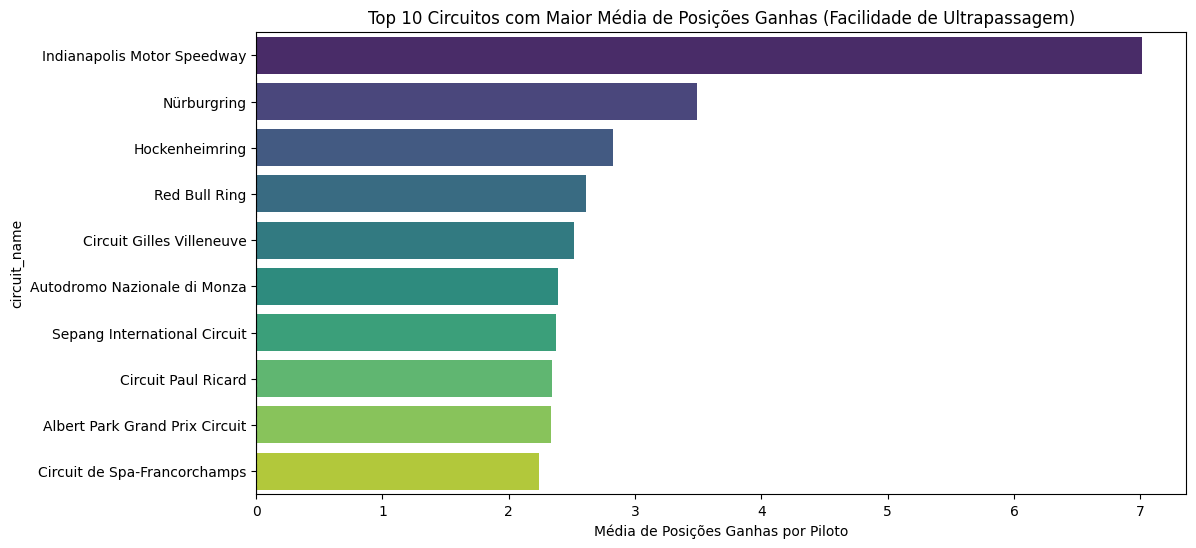

In [28]:
# Filtrar apenas quem terminou a corrida para medir performance
finishers = df[df['status'].str.contains('Finished')].copy()

# Calcular Delta: Positivo = Ganhou posições, Negativo = Perdeu posições
finishers['positions_gained'] = finishers['grid'] - finishers['positionOrder']

# Agrupar por circuito (apenas circuitos com muitas corridas)
circuit_stats = finishers.groupby('circuit_name')['positions_gained'].agg(['mean', 'count'])
circuit_stats = circuit_stats[circuit_stats['count'] > 100] # Pelo menos ~100 corridas na história

# Top 10 Pistas com mais ganhos de posição
top_overtake_tracks = circuit_stats.sort_values(by='mean', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_overtake_tracks['mean'], y=top_overtake_tracks.index, palette='viridis')
plt.title('Top 10 Circuitos com Maior Média de Posições Ganhas (Facilidade de Ultrapassagem)')
plt.xlabel('Média de Posições Ganhas por Piloto')
plt.axvline(0, color='black', linestyle='--')
plt.show()

## Conversão de Pole Position
A largada na primeira posição é historicamente a maior vantagem competitiva na Fórmula 1. Essa análise temporal mostra a probabilidade condicional de vitória, uma vez que o piloto largou na *Pole Position*.

Além da taxa anual bruta (representada em cinza), foi aplicada uma **média móvel de 5 anos** (linha de tendência em destaque) para identificar mudanças estruturais na competitividade da categoria. Tendências de alta indicam eras onde a posição de pista foi determinante (dificuldade de ultrapassagem), enquanto tendências de baixa sugerem maior variabilidade e disputas durante a corrida.

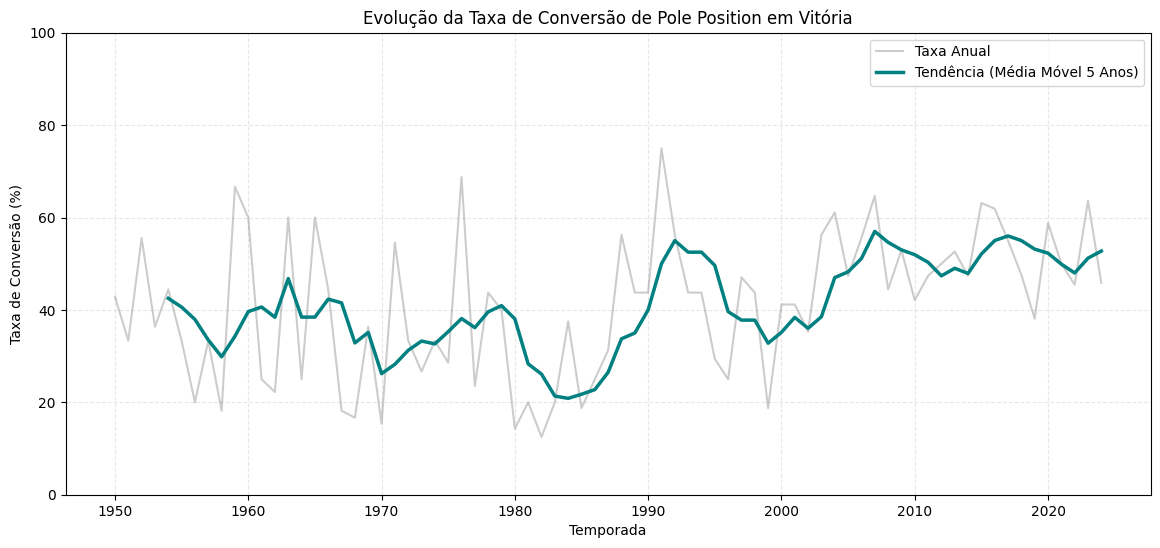

In [29]:
# Filtrar Poles e converter para binário
poles = df[df['grid'] == 1].copy()
poles['converted_win'] = (poles['positionOrder'] == 1).astype(int)

# Agrupar por ano
conversion_yearly = poles.groupby('year')['converted_win'].mean() * 100

plt.figure(figsize=(14, 6))

# Linha dos dados brutos
sns.lineplot(x=conversion_yearly.index, y=conversion_yearly.values, 
             color='gray', alpha=0.4, label='Taxa Anual')

# Linha de Tendência (Média Móvel de 5 anos)
sns.lineplot(x=conversion_yearly.index, y=conversion_yearly.rolling(window=5).mean(), 
             color='teal', linewidth=2.5, label='Tendência (Média Móvel 5 Anos)')

plt.title('Evolução da Taxa de Conversão de Pole Position em Vitória')
plt.ylabel('Taxa de Conversão (%)')
plt.xlabel('Temporada')
plt.ylim(0, 100)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()

# Clusterização

## Clusterização de Pilotos: Identificação de Perfis de Performance

Foram aplicadas técnicas de **Aprendizado Não-Supervisionado** para segmentar os pilotos em grupos distintos baseados em métricas de carreira, em vez de simples resultados brutos. O objetivo é identificar tipos de pilotos (ex: Lendas, Promessas, Medianos...).

### Metodologia
1.  **Engenharia de Atributos:** Foram criados indicadores compostos para capturar nuances, como:
    * `team_point_share`: A dominância do piloto sobre seu companheiro de equipe.
    * `crash_rate`: A propensão a acidentes.
    * `positions_gained`: A capacidade de recuperação em corrida.
2.  **Filtragem e Escalonamento:** A análise foi restrita a pilotos com mais de 20 corridas para garantir significância estatística. Os dados foram normalizados (`StandardScaler`) para evitar que variáveis de escalas diferentes (ex: Idade vs. Taxa de Vitória) distorçam o cálculo de distância.
3.  **Modelagem:** Foi utilizado primeiramente o algoritmo **K-Means**, definindo o número ideal de clusters ($k=4$) através da análise da inércia (Método do Cotovelo) e logo em seguida foi utilizado o **Clusterização Hierárquica**.
4.  **Visualização:** O **PCA (Análise de Componentes Principais)** foi aplicado para reduzir a dimensionalidade e permitir a visualização gráfica dos grupos em um plano 2D.

In [ ]:
# Feature Engineering

# Cálculo de Idade
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Calcular a idade exata em cada corrida em anos
df['driver_age'] = (df['date'] - df['dob']).dt.days / 365.25

df['is_win'] = (df['positionOrder'] == 1).astype(int)
df['is_podium'] = (df['positionOrder'] <= 3).astype(int)
finished_mask = df['status'].str.contains('Finished') | df['status'].str.contains('\+')
df['is_dnf'] = (~finished_mask).astype(int)
driver_errors = ['Collision', 'Accident', 'Spun off', 'Collision damage']
df['is_crash'] = df['status'].str.contains('|'.join(driver_errors), case=False, regex=True).astype(int)
df['positions_gained'] = np.where(finished_mask, df['grid'] - df['positionOrder'], np.nan)
team_race_points = df.groupby(['year', 'raceId', 'constructorId'])['points'].transform('sum')
df['team_point_share'] = df['points'] / team_race_points
df['team_point_share'] = df['team_point_share'].fillna(0)

# Features de Tempo/Ritmo
df['fastest_lap_rank'] = pd.to_numeric(df['rank'], errors='coerce')
df['qualy_race_diff'] = df['grid'] - df['fastest_lap_rank']

# Agregação por piloto
driver_stats = df.groupby('driverRef').filter(lambda x: len(x) > 20)

data = driver_stats.groupby('driverRef').agg({
    'grid': 'mean',
    'positionOrder': 'mean',
    'points': 'mean',
    'is_win': 'mean',       
    'is_podium': 'mean',
    'is_dnf': 'mean',
    'is_crash': 'mean',
    'positions_gained': 'mean',
    'team_point_share': 'mean',
    'fastest_lap_rank': 'mean',
    'qualy_race_diff': 'mean',
    'raceId': 'count',          
    'year': 'nunique',           
    'driver_age': 'mean'         
}).rename(columns={
    'raceId': 'total_races',     
    'year': 'total_seasons',     
    'driver_age': 'avg_age',     
    'is_win': 'win_rate',       
    'is_podium': 'podium_rate', 
    'is_dnf': 'dnf_rate',
    'is_crash': 'crash_rate',
    'fastest_lap_rank': 'avg_fastest_lap_rank'
})
data = data.fillna(0)

# Escalonamento
features_list = [
    'grid', 'positionOrder', 'points', 
    'podium_rate', 'dnf_rate', 'crash_rate', 
    'positions_gained', 'team_point_share',
    'avg_fastest_lap_rank', 'qualy_race_diff',
    'total_races', 'total_seasons', 'avg_age'
]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[features_list])

### KMeans

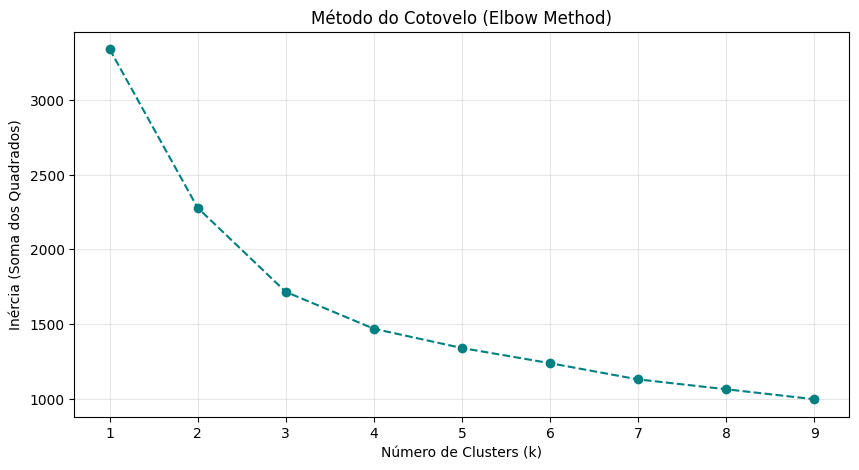

In [31]:
# Inércia para método do cotovelo
inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='teal')
plt.title('Método do Cotovelo (Elbow Method)')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia (Soma dos Quadrados)')
plt.grid(True, alpha=0.3)
plt.show()

#  Avaliando o gráfico de inércia foi escolhido um k=4 para a clusterização utilizando o KMeans

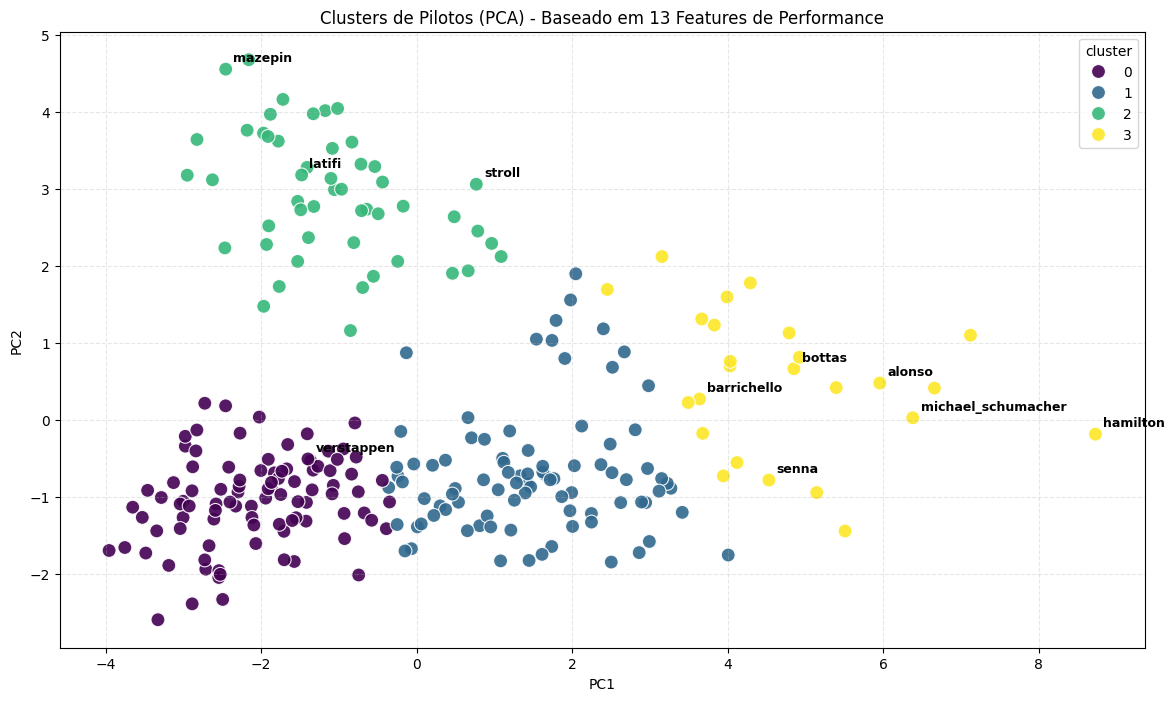


Perfil Médio de cada Cluster (Valores Originais):


,grid,positionOrder,points,podium_rate,dnf_rate,crash_rate,positions_gained,team_point_share,avg_fastest_lap_rank,qualy_race_diff,total_races,total_seasons,avg_age
cluster,,,,,,,,,,,,,
0,14.42,17.10,0.16,0.01,0.66,0.13,8.01,0.06,0.00,0.00,54.84,5.09,28.89
1,9.32,10.99,1.50,0.17,0.45,0.10,3.15,0.25,1.61,-0.04,111.60,9.78,31.70
2,15.73,14.74,0.51,0.01,0.28,0.12,2.67,0.10,13.94,1.64,61.54,3.86,25.60
3,6.85,8.19,6.08,0.31,0.21,0.07,1.00,0.43,6.38,-0.02,221.84,12.56,28.91


In [32]:
# Clusterização
k_final = 4
kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=10)
data['cluster'] = kmeans.fit_predict(X_scaled)

# Visualização com PCA (Redução de Dimensionalidade)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
data['pca_1'] = X_pca[:, 0]
data['pca_2'] = X_pca[:, 1]

plt.figure(figsize=(14, 8))
sns.scatterplot(data=data, x='pca_1', y='pca_2', hue='cluster', palette='viridis', s=100, alpha=0.9)

# Anotando alguns nomes famosos para interpretar o gráfico
notable_drivers = ['hamilton', 'michael_schumacher', 'senna', 'verstappen', 'alonso', 
                   'latifi', 'mazepin', 'stroll', 'bottas', 'barrichello']

for driver in notable_drivers:
    if driver in data.index:
        plt.text(data.loc[driver, 'pca_1']+0.1, 
                 data.loc[driver, 'pca_2']+0.1, 
                 driver, fontsize=9, fontweight='bold', color='black')

plt.title(f'Clusters de Pilotos (PCA) - Baseado em {len(features_list)} Features de Performance')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

# Interpretação Estatística dos Clusters
print("\nPerfil Médio de cada Cluster (Valores Originais):")
data.groupby('cluster')[features_list].mean().round(2)

### Hierarchical Clustering

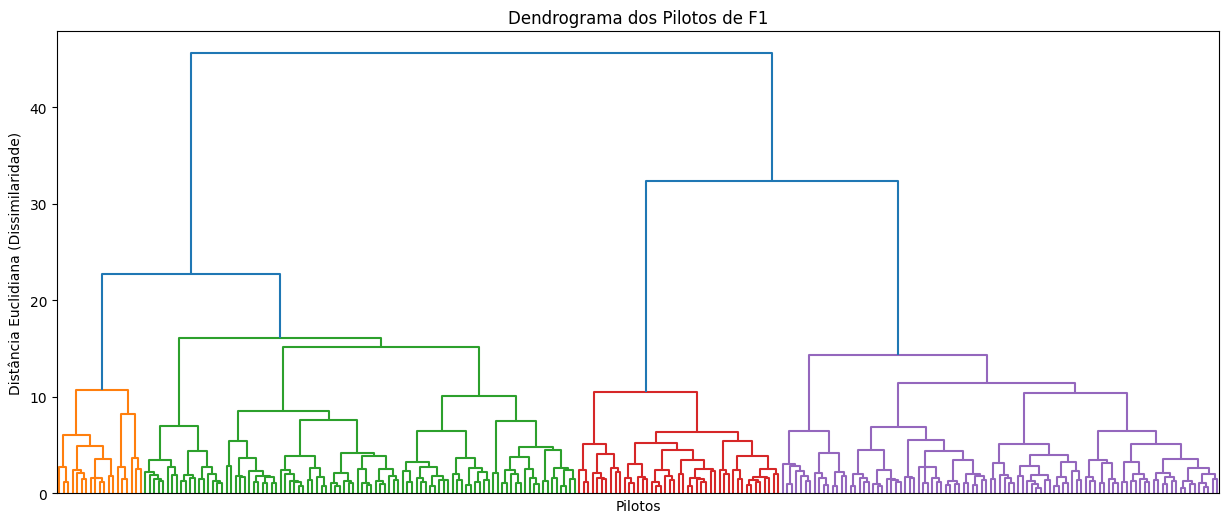

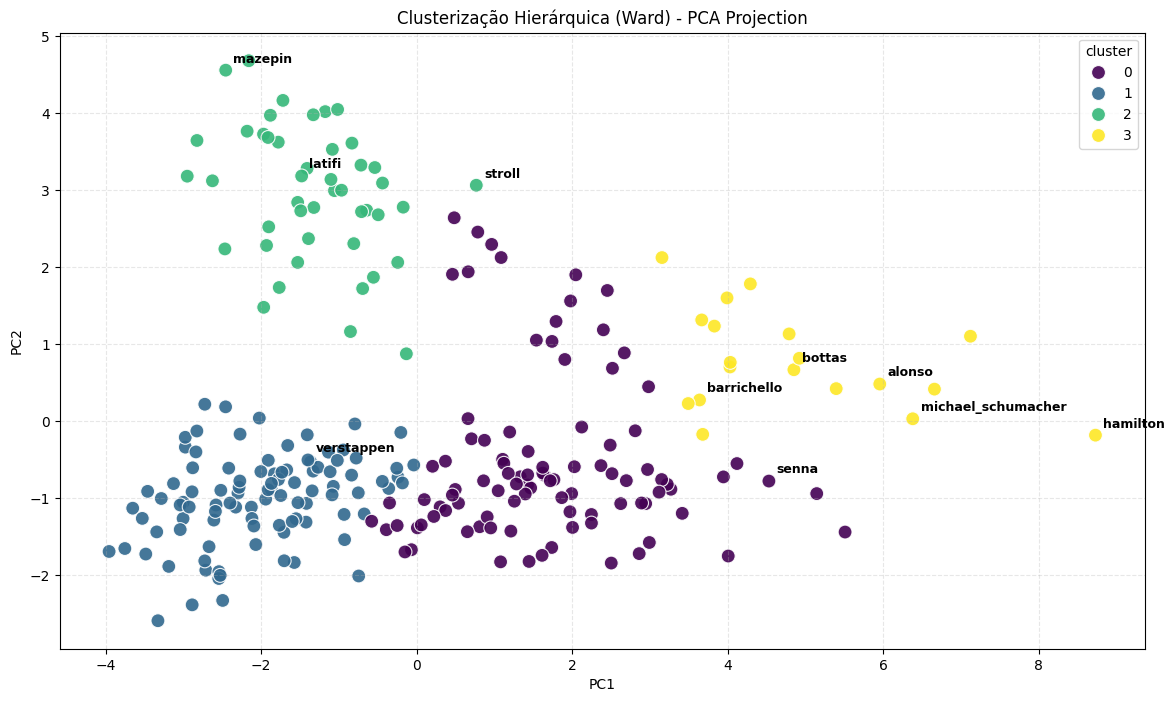


Perfil Médio de cada Cluster (Hierarchical):


grid       positionOrder       points       podium_rate        \
          mean count          mean count   mean count        mean count   
cluster                                                                   
0         9.14    96         10.93    96   1.70    96        0.18    96   
1        14.31    97         16.85    97   0.18    97        0.01    97   
2        16.08    45         14.95    45   0.38    45        0.00    45   
3         7.56    19          8.38    19   6.68    19        0.27    19   

        dnf_rate        ... avg_fastest_lap_rank       qualy_race_diff        \
            mean count  ...                 mean count            mean count   
cluster                 ...                                                    
0           0.43    96  ...                 2.19    96            0.01    96   
1           0.65    97  ...                 0.00    97            0.00    97   
2           0.29    45  ...                14.19    45            1.73    45   
3           0.18    19  ...                 7.85    19           -0.00    19   

        total_races       total_seasons       avg_age        
               mean count          mean count    mean count  
cluster                                                      
0            117.53    96          9.88    96   31.30    96  
1             52.08    97          4.96    97   28.97    97  
2             54.24    45          3.53    45   25.70    45  
3            253.84    19         13.58    19   28.25    19  

[4 rows x 26 columns]

In [ ]:
plt.figure(figsize=(15, 6))
plt.title('Dendrograma dos Pilotos de F1')
plt.xlabel('Pilotos')
plt.ylabel('Distância Euclidiana (Dissimilaridade)')

# Criando o dendrograma
dendrogram = sch.dendrogram(
    sch.linkage(X_scaled, method='ward'),
    no_labels=True,
    color_threshold=20)
plt.show()

n_clusters = 4
hc = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
data['cluster'] = hc.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
data['pca_1'] = X_pca[:, 0]
data['pca_2'] = X_pca[:, 1]

plt.figure(figsize=(14, 8))
sns.scatterplot(data=data, x='pca_1', y='pca_2', hue='cluster', palette='viridis', s=100, alpha=0.9)

notable_drivers = ['hamilton', 'michael_schumacher', 'senna', 'verstappen', 'alonso', 
                   'latifi', 'mazepin', 'stroll', 'bottas', 'barrichello']

for driver in notable_drivers:
    if driver in data.index:
        plt.text(data.loc[driver, 'pca_1']+0.1, 
                 data.loc[driver, 'pca_2']+0.1, 
                 driver, fontsize=9, fontweight='bold', color='black')

plt.title(f'Clusterização Hierárquica (Ward) - PCA Projection')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

print("\nPerfil Médio de cada Cluster (Hierarchical):")

data.groupby('cluster')[features_list].agg(['mean', 'count']).round(2)

## Clusterização de Circuitos: Tipologia e Características de Pista

Para que o modelo preditivo generalize corretamente, é importante que ele entenda o **contexto físico** de cada Grande Prêmio. Um circuito de rua (ex: Mônaco) exige características de pilotagem e acerto do carro opostas às de um circuito mais veloz (ex: Monza).

### Engenharia de Atributos (Track Profiling)
Foram utilizados os dados da **Era Moderna (pós-2000)**, criado um perfil métrico detalhado para cada circuito com mais de 5 corridas realizadas, capturando:

* **Pole Advantage:** A correlação entre largar em 1º e vencer (indicativo de dificuldade de ultrapassagem).
* **Safety Car Probability:** Probabilidade de interrupções, inferida através da frequência de voltas anômalas (lentas).
* **Mechanical Stress & Crash Rate:** O quão "dura" a pista é para o equipamento e para o piloto.
* **Pit Intensity:** Complexidade estratégica baseada no volume de paradas.

### Modelagem Não-Supervisionada
Dois algoritmos foram aplicados **K-Means:** e **Clusterização Hierárquica**.

Os dois resultados foram projetados em 2D utilizando **PCA** para facilitar a interpretação visual dos grupos.

In [ ]:
def str_time_to_seconds(t_str):
    """Converte strings de tempo (ex: '1:24.500') para segundos (float)."""
    if pd.isna(t_str) or str(t_str).strip() == '' or '\\N' in str(t_str):
        return np.nan
    try:
        parts = str(t_str).split(':')
        if len(parts) == 2:
            return float(parts[0]) * 60 + float(parts[1])
        else:
            return float(t_str)
    except:
        return np.nan

df['fastestLapSpeed'] = pd.to_numeric(df['fastestLapSpeed'], errors='coerce')
df['lap_time_sec'] = df['fastestLapTime'].apply(str_time_to_seconds)

# Filtrar anos
modern_f1 = df[df['year'] >= 2000].copy()

# Feature Engineering

# POLE ADVANTAGE: Conversão de Pole em Vitória
poles = modern_f1[modern_f1['grid'] == 1].groupby('circuit_name')['positionOrder'].apply(lambda x: (x == 1).mean())

# CRASH RATE: Porcentagem de acidentes (Erro Humano/Pista Perigosa)
crash_status = ['Collision', 'Accident', 'Spun off', 'Collision damage']
modern_f1['is_crash'] = modern_f1['status'].str.contains('|'.join(crash_status), case=False, regex=True).astype(int)
crash_rate = modern_f1.groupby('circuit_name')['is_crash'].mean()

# MECHANICAL STRESS: Porcentagem de falhas mecânicas
mech_status = ['Engine', 'Gearbox', 'Transmission', 'Clutch', 'Hydraulics', 'Electrical', 
               'Brakes', 'Radiator', 'Suspension', 'Power Unit', 'Oil leak', 'Overheating']
modern_f1['is_mech_fail'] = modern_f1['status'].str.contains('|'.join(mech_status), case=False, regex=True).astype(int)
mech_stress = modern_f1.groupby('circuit_name')['is_mech_fail'].mean()

# OVERTAKE FACTOR: Dinâmica de Posições (apenas quem terminou)
finishers = modern_f1[modern_f1['status'].str.contains('Finished|\+')]
finishers['pos_change'] = abs(finishers['grid'] - finishers['positionOrder'])
overtake_factor = finishers.groupby('circuit_name')['pos_change'].mean()

# VELOCIDADE MÉDIA (Traçado)
avg_speed = modern_f1.groupby('circuit_name')['fastestLapSpeed'].mean()

# TEMPO DE VOLTA (Tamanho da Pista)
avg_lap_time = modern_f1.groupby('circuit_name')['lap_time_sec'].mean()

# ALTITUDE (Fator Físico)
altitude = modern_f1.groupby('circuit_name')['alt'].max()

# PIT INTENSITY (Estratégia/Pneus)
# Cruzar pitstops com circuitos
stops_w_circuit = df_pitstops.merge(modern_f1[['raceId', 'circuit_name']].drop_duplicates(), on='raceId')
stops_per_race = stops_w_circuit.groupby('circuit_name')['stop'].count()
races_count = modern_f1.groupby('circuit_name')['raceId'].nunique()
drivers_per_race = modern_f1.groupby('circuit_name')['driverId'].nunique() / races_count
pit_intensity = (stops_per_race / races_count) / drivers_per_race

# SAFETY CAR PROBABILITY
# Analisar todas as voltas (df_laps). Se muitas voltas são lentas, mais provável SC/VSC
laps_w_circuit = df_lap_times.merge(modern_f1[['raceId', 'circuit_name']].drop_duplicates(), on='raceId')
race_medians = laps_w_circuit.groupby('raceId')['milliseconds'].median().reset_index()
race_medians.rename(columns={'milliseconds': 'race_median_time'}, inplace=True)
laps_analysis = laps_w_circuit.merge(race_medians, on='raceId')
laps_analysis['is_slow_lap'] = laps_analysis['milliseconds'] > (laps_analysis['race_median_time'] * 1.35)
sc_probability = laps_analysis.groupby('circuit_name')['is_slow_lap'].mean()

track_data = pd.DataFrame({
    'pole_advantage': poles,
    'crash_rate': crash_rate,
    'mech_stress': mech_stress,
    'overtake_factor': overtake_factor,
    'avg_speed': avg_speed,
    'avg_lap_time': avg_lap_time,
    'pit_intensity': pit_intensity,
    'sc_probability': sc_probability,
    'altitude': altitude,
    'races_held': races_count
})

# Filtro para remover pistas com menos de 5 corridas
track_data = track_data[track_data['races_held'] >= 5]

# Preencher NaNs
track_data['pit_intensity'] = track_data['pit_intensity'].fillna(track_data['pit_intensity'].median())
track_data['sc_probability'] = track_data['sc_probability'].fillna(0)
track_data = track_data.dropna()

# Escalonamento
features = ['pole_advantage', 'crash_rate', 'mech_stress', 'overtake_factor', 
            'avg_speed', 'avg_lap_time', 'pit_intensity', 'altitude', 'sc_probability']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(track_data[features])

### KMeans

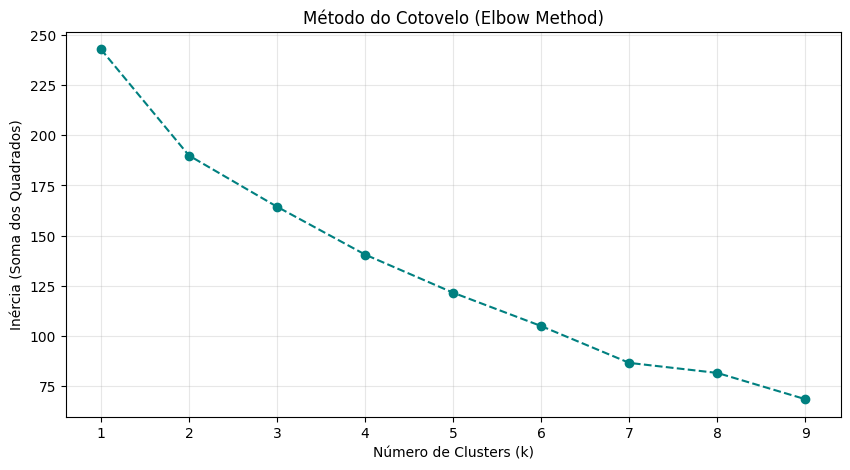

In [35]:
# Inércia para método do cotovelo
inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='teal')
plt.title('Método do Cotovelo (Elbow Method)')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia (Soma dos Quadrados)')
plt.grid(True, alpha=0.3)
plt.show()

#  Avaliando o gráfico de inércia foi escolhido um k=4 para a clusterização utilizando o KMeans

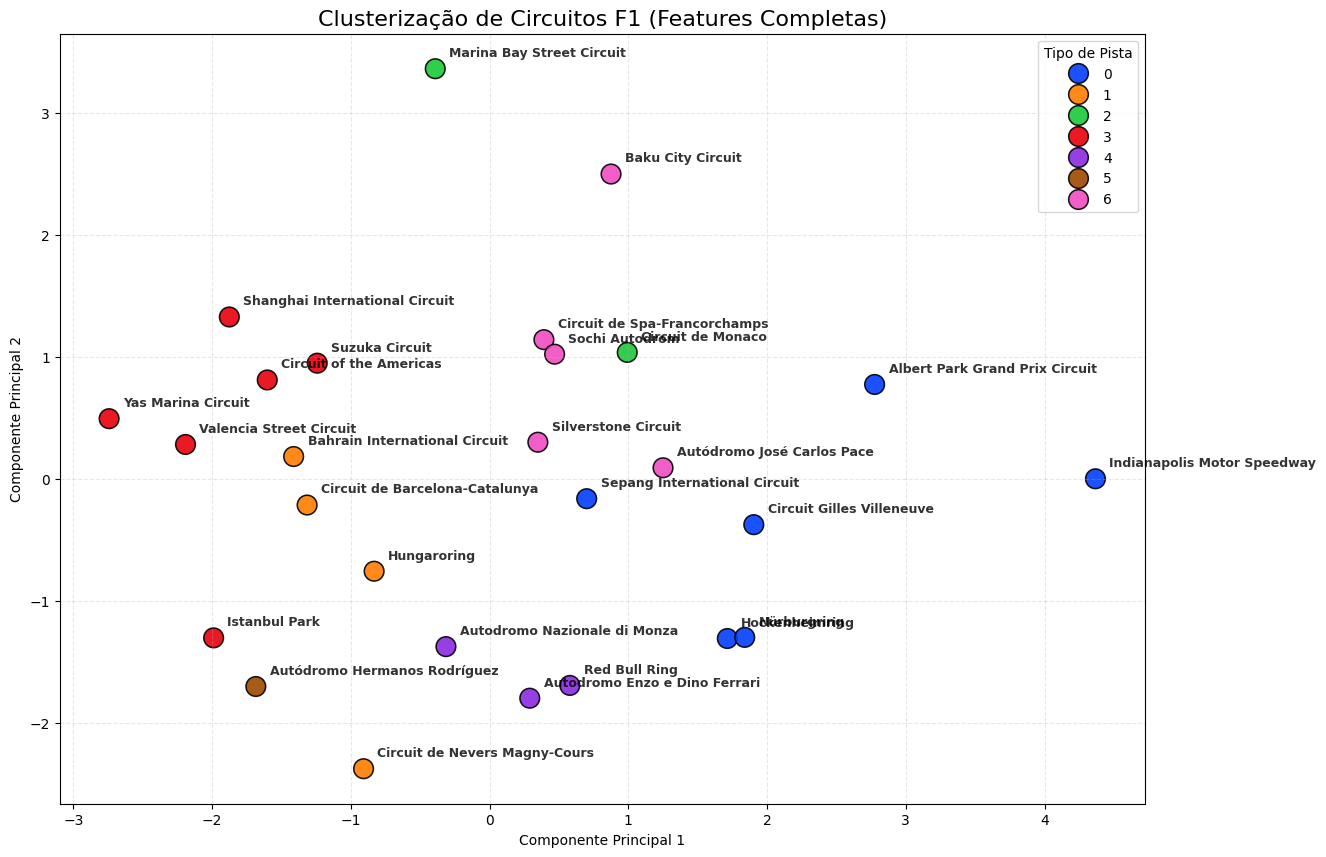

In [36]:
# Clusterização
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
track_data['cluster'] = kmeans.fit_predict(X_scaled)

# Visualização com PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
track_data['pca_1'] = X_pca[:, 0]
track_data['pca_2'] = X_pca[:, 1]

plt.figure(figsize=(14, 10))
sns.scatterplot(data=track_data, x='pca_1', y='pca_2', hue='cluster', 
                palette='bright', s=200, alpha=0.9, edgecolor='black')

# Adicionar nomes das pistas
for track in track_data.index:
    plt.text(track_data.loc[track, 'pca_1']+0.1, 
             track_data.loc[track, 'pca_2']+0.1, 
             track, fontsize=9, fontweight='bold', alpha=0.8)

plt.title('Clusterização de Circuitos F1 (Features Completas)', fontsize=16)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title='Tipo de Pista')
plt.show()

In [37]:
print("\n--- Perfil Médio de Cada Cluster ---")
track_data.groupby('cluster')[features].mean().T.round(3)


--- Perfil Médio de Cada Cluster ---


cluster,0,1,2,3,4,5,6
pole_advantage,0.415,0.482,0.625,0.604,0.528,0.444,0.348
crash_rate,0.115,0.056,0.134,0.060,0.057,0.060,0.093
mech_stress,0.141,0.108,0.092,0.054,0.121,0.071,0.083
overtake_factor,3.871,2.890,3.240,2.956,3.238,2.610,3.487
avg_speed,203.918,198.715,160.279,200.904,227.324,189.701,213.479
avg_lap_time,86.209,85.431,93.859,98.970,79.315,81.706,97.273
pit_intensity,3.543,6.154,5.547,4.717,3.622,5.578,5.409
altitude,157.500,152.000,12.500,58.000,292.333,2227.000,266.800
sc_probability,0.036,0.017,0.052,0.027,0.033,0.029,0.053


### Hierarchical Clustering

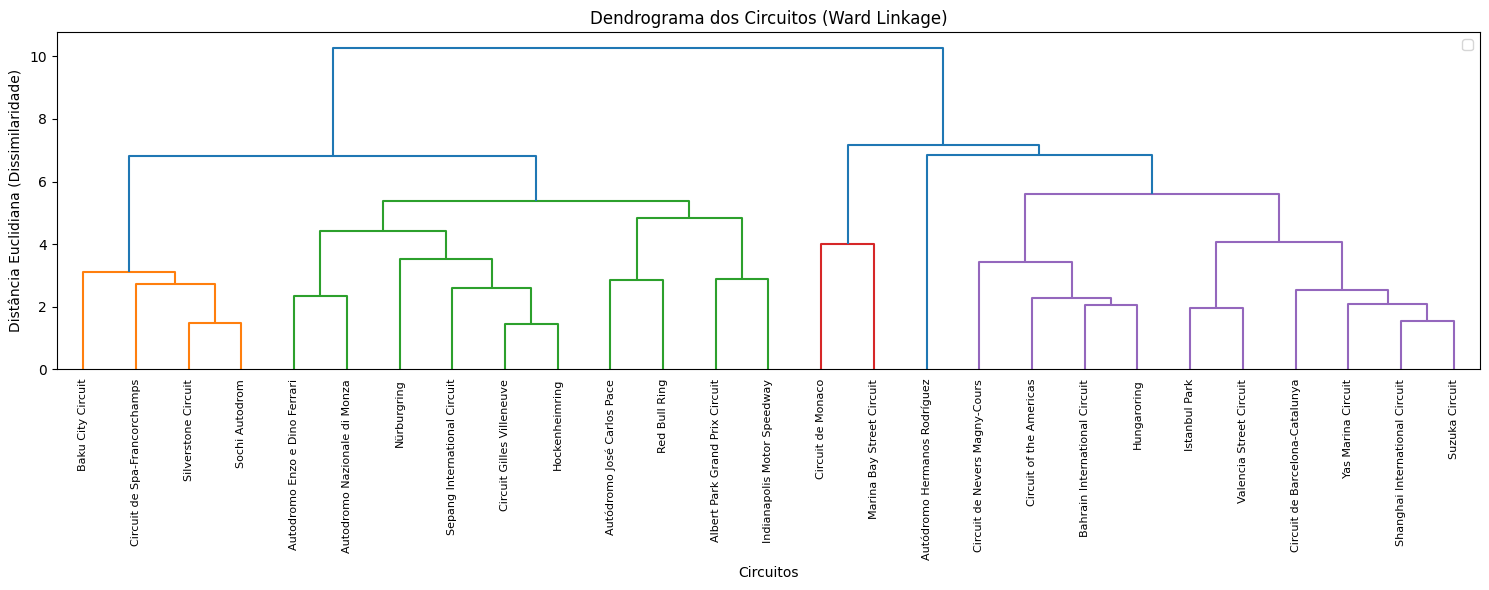

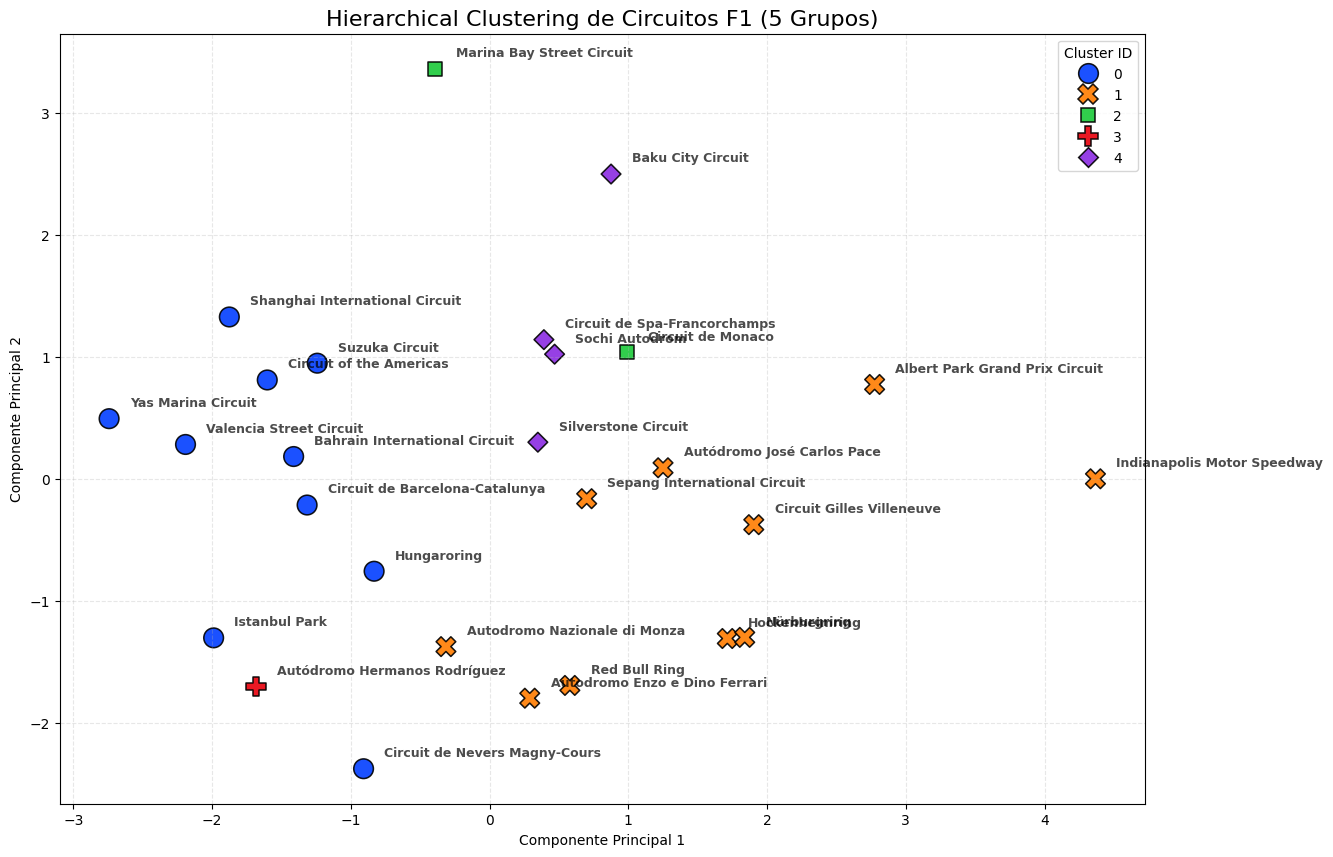

In [38]:
plt.figure(figsize=(15, 6))
plt.title('Dendrograma dos Circuitos (Ward Linkage)')
plt.xlabel('Circuitos')
plt.ylabel('Distância Euclidiana (Dissimilaridade)')

dendrogram = sch.dendrogram(
    sch.linkage(X_scaled, method='ward'),
    labels=track_data.index,
    color_threshold=6,
    leaf_rotation=90,
    leaf_font_size=8
)
plt.legend()
plt.tight_layout()
plt.show()


n_clusters_h = 5 
hc = AgglomerativeClustering(n_clusters=n_clusters_h, metric='euclidean', linkage='ward')
track_data['cluster'] = hc.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
track_data['pca_1'] = X_pca[:, 0]
track_data['pca_2'] = X_pca[:, 1]

plt.figure(figsize=(14, 10))
sns.scatterplot(data=track_data, x='pca_1', y='pca_2', hue='cluster', 
                palette='bright', s=200, alpha=0.9, edgecolor='black', style='cluster')

for track in track_data.index:
    plt.text(track_data.loc[track, 'pca_1']+0.15, 
             track_data.loc[track, 'pca_2']+0.1, 
             track, fontsize=9, fontweight='bold', alpha=0.7)

plt.title(f'Hierarchical Clustering de Circuitos F1 ({n_clusters_h} Grupos)', fontsize=16)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title='Cluster ID')
plt.show()

In [39]:
print("\n--- Perfil Médio de Cada Cluster (Hierarchical) ---")
numeric_cols = ['avg_speed', 'sc_probability', 'crash_rate', 'overtake_factor', 'pit_intensity', 'altitude']
display(track_data.groupby('cluster')[numeric_cols].mean().sort_values(by='avg_speed', ascending=False))


--- Perfil Médio de Cada Cluster (Hierarchical) ---


,avg_speed,sc_probability,crash_rate,overtake_factor,pit_intensity,altitude
cluster,,,,,,
4,215.687682,0.053846,0.088272,3.451659,5.168515,137.25
1,211.012649,0.036597,0.097695,3.657251,3.849930,260.70
0,200.028203,0.023043,0.058273,2.929930,5.291438,95.60
3,189.700640,0.028530,0.060440,2.610390,5.577778,2227.00
2,160.279001,0.052079,0.133679,3.239791,5.547297,12.50


## Clusterização de Construtores: Performance Organizacional e Confiabilidade

Na Fórmula 1, o campeonato de construtores é tão importante quanto o de pilotos. Aqui foram analisadas as **Equipes** como entidades organizacionais, buscando agrupar times com perfis operacionais semelhantes.

### Engenharia de Atributos
Para capturar a "saúde" e a competitividade de uma equipe, foram calculadas métricas além da pontuação bruta:

* **Eficiência Operacional:** Média de tempo de *Pit Stop*, refletindo o treinamento da equipe de mecânicos.
* **Confiabilidade Mecânica:** Taxa de falhas técnicas (motor, câmbio, hidráulica), indicando a qualidade da engenharia.
* **Dominância:** Taxa de vitórias (*Win Rate*) e média de pontos por corrida.
* **Competitividade Pura:** Posição média de largada (*Avg Grid*).

### Modelagem
Assim como na análise de circuitos, foram aplicadas técnicas de aprendizado não-supervisionado (**K-Means** e **Clusterização Hierárquica**) sobre os dados normalizados. O objetivo é identificar as camadas hierárquicas da F1 moderna de forma estatística, validando os grupos através de projeções PCA e Dendrogramas.

In [ ]:
# Filtrando anos
team_df = df[df['year'] >= 2014].copy()

# Feature Engineering

# CONFIABILIDADE (Falhas Mecânicas)
mech_status = ['Engine', 'Gearbox', 'Transmission', 'Clutch', 'Hydraulics', 'Electrical', 
               'Brakes', 'Radiator', 'Suspension', 'Power Unit', 'Oil leak', 'Overheating', 'Turbo']
team_df['is_mech_fail'] = team_df['status'].str.contains('|'.join(mech_status), case=False, regex=True).astype(int)

# PERFORMANCE DE PIT STOP (Operacional)
pit_stats = df_pitstops.merge(team_df[['raceId', 'constructorRef']], on='raceId')
pit_stats['seconds'] = pit_stats['milliseconds'] / 1000
pit_stats = pit_stats[pit_stats['seconds'] < 40]

# Agregação de Pit Stops por Equipe
pit_metrics = pit_stats.groupby('constructorRef').agg({
    'seconds': 'mean'
}).rename(columns={'seconds': 'avg_pit_time'})

team_data = team_df.groupby('constructorRef').agg({
    'points': 'sum',                 # Total de Pontos
    'raceId': 'nunique',             # Total de Corridas
    'grid': 'mean',                  # Grid Médio
    'positionOrder': 'mean',         # Chegada Média
    'is_mech_fail': 'mean',          # Taxa de Quebra (%)
}).rename(columns={'grid': 'avg_grid', 'positionOrder': 'avg_finish', 'is_mech_fail': 'mech_fail_rate'})

# Calcular Pontos por Corrida
team_data['points_per_race'] = team_data['points'] / team_data['raceId']

# CALCULAR WIN RATE (Vitórias / Total de Corridas)
wins = team_df[team_df['positionOrder'] == 1].groupby('constructorRef')['raceId'].count()
team_data['wins'] = wins
team_data['wins'] = team_data['wins'].fillna(0) # Quem nunca venceu recebe 0
team_data['win_rate'] = team_data['wins'] / team_data['raceId']

team_data = team_data.join(pit_metrics, how='inner')

# Remover equipes com poucas corridas na era moderna
team_data = team_data[team_data['raceId'] > 20]

features = ['points_per_race', 'avg_grid', 'mech_fail_rate', 'avg_pit_time', 'win_rate']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(team_data[features])

### KMeans

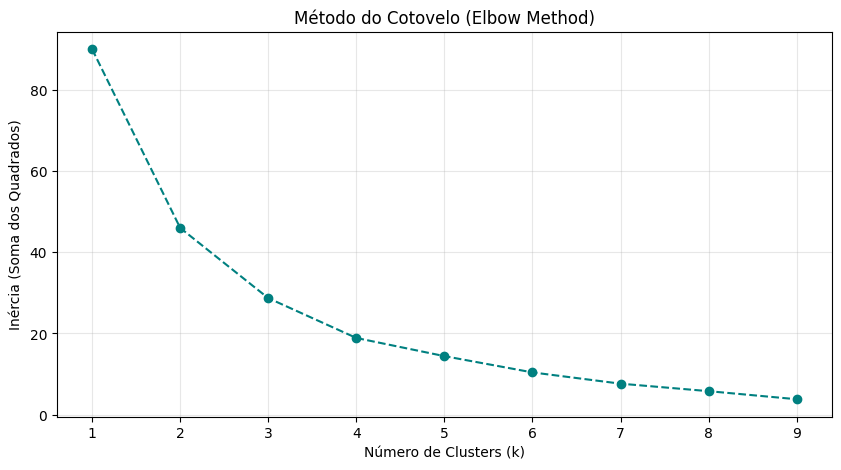

In [41]:
# Inércia para método do cotovelo
inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='teal')
plt.title('Método do Cotovelo (Elbow Method)')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia (Soma dos Quadrados)')
plt.grid(True, alpha=0.3)
plt.show()

#  Avaliando o gráfico de inércia foi escolhido um k=4 para a clusterização utilizando o KMeans

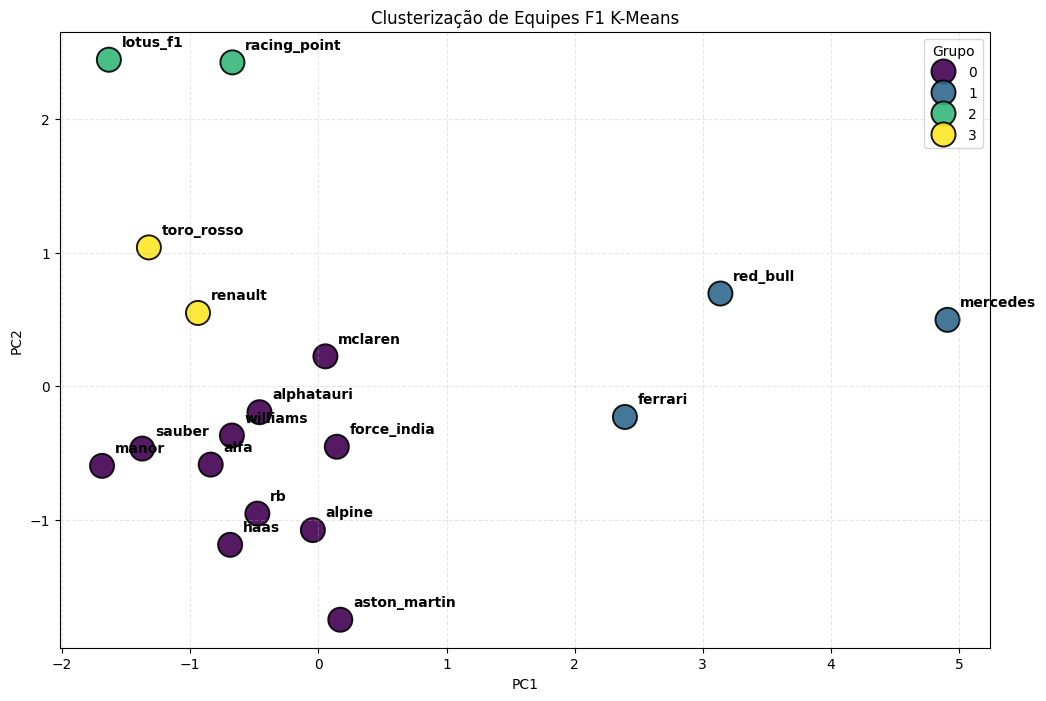

In [42]:
# Definido K=4 de acordo com o gráfico de inércia
k_final = 4
kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=10)
team_data['cluster'] = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
team_data['pca_1'] = X_pca[:, 0]
team_data['pca_2'] = X_pca[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(data=team_data, x='pca_1', y='pca_2', hue='cluster', 
                palette='viridis', s=300, alpha=0.9, edgecolor='black')

# Adicionar nomes das equipes
for team in team_data.index:
    plt.text(team_data.loc[team, 'pca_1']+0.1, 
             team_data.loc[team, 'pca_2']+0.1, 
             team, fontsize=10, fontweight='bold')

plt.title('Clusterização de Equipes F1 K-Means')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title='Grupo')
plt.show()

### Hierarchical Clustering

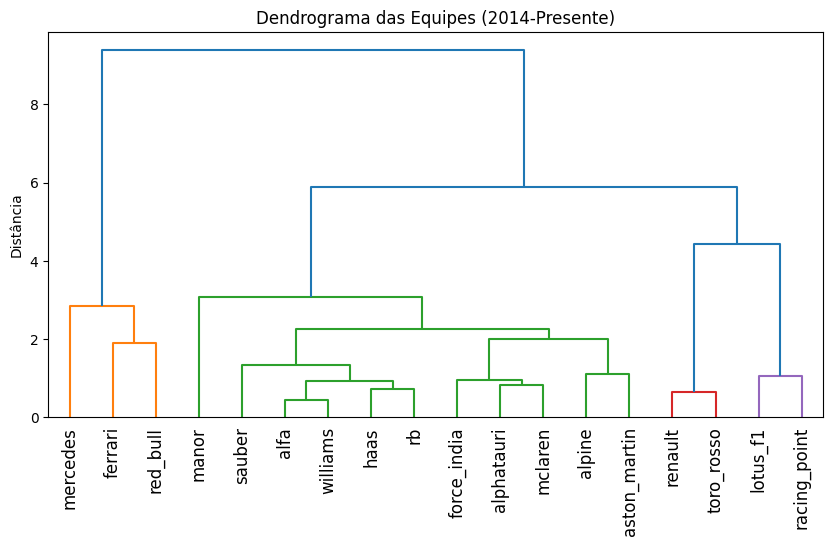

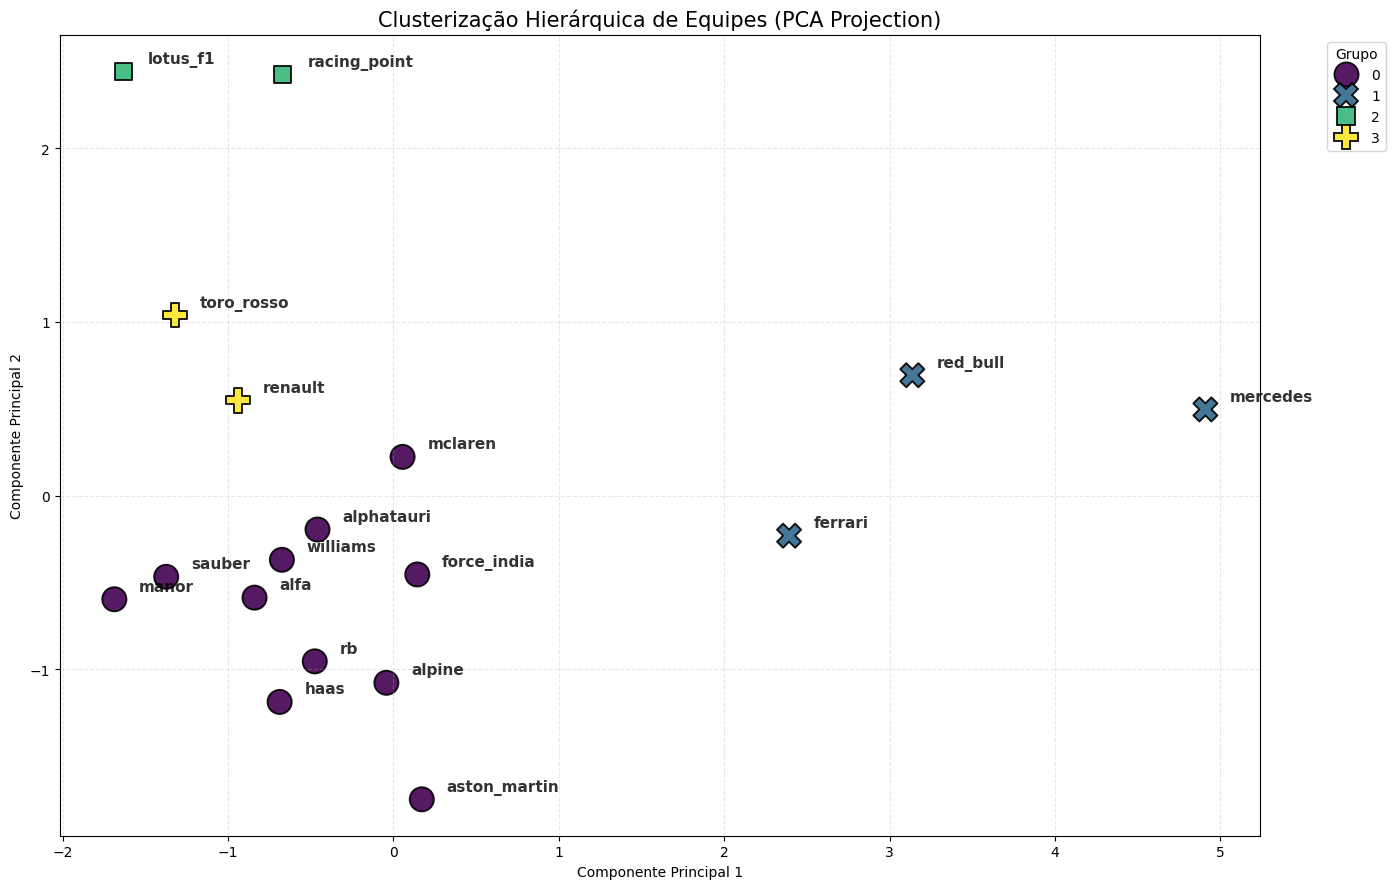

In [43]:
plt.figure(figsize=(10, 5))
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method='ward'), color_threshold=4, leaf_rotation=90, labels=team_data.index)
plt.title('Dendrograma das Equipes (2014-Presente)')
plt.ylabel('Distância')
plt.show()
    
n_clusters = 4
hc = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
team_data['cluster'] = hc.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
team_data['pca_1'] = X_pca[:, 0]
team_data['pca_2'] = X_pca[:, 1]


plt.figure(figsize=(14, 9))
sns.scatterplot(data=team_data, x='pca_1', y='pca_2', hue='cluster', 
                palette='viridis', s=300, alpha=0.9, edgecolor='black', style='cluster')
for team in team_data.index:
    plt.text(team_data.loc[team, 'pca_1']+0.15, 
             team_data.loc[team, 'pca_2']+0.05, 
             team, fontsize=11, fontweight='bold', alpha=0.8)

plt.title(f'Clusterização Hierárquica de Equipes (PCA Projection)', fontsize=15)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title='Grupo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [44]:
# Perfil dos Clusters
print("\n--- Perfil Médio dos Grupos ---")
display(team_data.groupby('cluster')[features].mean().sort_values(by='points_per_race', ascending=False))


--- Perfil Médio dos Grupos ---


,points_per_race,avg_grid,mech_fail_rate,avg_pit_time,win_rate
cluster,,,,,
1,24.111842,5.190789,0.042398,24.524422,0.318713
2,4.881579,12.500000,0.098684,24.865872,0.013158
0,3.677166,12.705158,0.056298,24.501914,0.004896
3,3.662769,12.196302,0.130682,24.503362,0.000000


# Previsão de posição final do grid
Aqui é consolidado o fluxo de trabalho de Machine Learning, implementando a transformação final dos dados e o treinamento dos algoritmos.

### 1. Engenharia de Atributos
Para capturar a complexidade da F1, foram calculadas novas variáveis que oferecem contexto além da telemetria:
* **Gap to P10 (`gap_to_p10`):** Diferença de tempo na qualificação para a zona de corte. Essencial para diferenciar carros de meio de grid.
* **Teammate Delta (`teammate_grid_delta`):** Performance relativa ao companheiro de equipe, isolando o fator "piloto" do fator "carro".
* **Track Affinity:** Histórico de pontos acumulados pelo piloto especificamente no circuito atual.

### 2. Estratégia de Modelagem (Random Forest & XGBoost)
O problema é abordado com dois algoritmos de *ensemble*, configurados para combater o **desbalanceamento de classes** (onde a classe *Winner* é muito rara):
* **Random Forest:** Configurado com `class_weight='balanced'` para aumentar a penalidade de erro nas classes minoritárias.
* **XGBoost:** Treinado com pesos de amostra calculados (`compute_sample_weight`) e objetivo `softprob` para maximizar a sensibilidade na detecção de vencedores e pódios.

### 3. Avaliação
A validação foca na **Acurácia Balanceada** e na **Matriz de Confusão**, permitindo verificar se o modelo distingue corretamente entre as classes críticas (ex: *Podium* vs. *Winner*) ou se está apenas superestimando a classe majoritária (*No_Points*).

Prever exatamente qual será a posição final de um piloto é difícil devido ao número de posições e diferentes ruídos que podem afetar o desempenho de um piloto. Por isso a estratégia aqui foi definir intervalos para as posições e prever qual intervalo a posição final do piloto irá cair. Para isso foram definidas 4 categorias:

1. Winner (P1)
2. Podium (P2-P3)
3. Points (P4-P10)
4. No Points (P11+)

In [45]:
def str_time_to_seconds(t_str):
    """Converte string de tempo (1:20.500) para segundos (float)."""
    if pd.isna(t_str) or str(t_str).strip() == '' or '\\N' in str(t_str):
        return np.nan
    try:
        parts = str(t_str).split(':')
        if len(parts) == 2: 
            return float(parts[0]) * 60 + float(parts[1])
        return float(t_str)
    except:
        return np.nan

def classify_position(pos):
    """Define as classes do Target."""
    if pos == 1: return 'Winner'
    elif pos <= 3: return 'Podium'
    elif pos <= 10: return 'Points'
    else: return 'No_Points'

### Feature Engineering
# Ordenando Cronologicamente
full_data = df.sort_values(by=['year', 'date', 'raceId']).copy()

## TRACK AFFINITY (Histórico na Pista)
full_data['track_points_cumsum'] = full_data.groupby(['driverRef', 'circuit_name'])['points'].cumsum().shift(1).fillna(0)
full_data['track_races_count'] = full_data.groupby(['driverRef', 'circuit_name']).cumcount()
full_data['driver_track_affinity'] = np.where(
    full_data['track_races_count'] > 0,
    full_data['track_points_cumsum'] / full_data['track_races_count'],
    0 
)

##TEAMMATE DELTA (Comparação no Grid)
team_grid_mean = full_data.groupby(['raceId', 'constructorId'])['grid'].transform('mean')
full_data['teammate_grid_delta'] = full_data['grid'] - team_grid_mean

## CHAMPIONSHIP STANDING (Classificação Pré-Corrida)
full_data['season_points'] = full_data.groupby(['year', 'driverRef'])['points'].cumsum().shift(1).fillna(0)
full_data['champ_standing'] = full_data.groupby(['year'])['season_points'].rank(ascending=False, method='min')

## TRACK DIFFICULTY (Importância da Pole - Feature Estática)
pole_win_prob = full_data[full_data['grid']==1].groupby('circuit_name')['positionOrder'].apply(lambda x: (x==1).mean())
full_data['track_pole_importance'] = full_data['circuit_name'].map(pole_win_prob)

## GAP TO P10, a ideia é ajudar o modelo a diferenciar quem pontua de quem não pontua
df_quali_proc = df_qualifying.copy()

# Converter tempos
for col in ['q1', 'q2', 'q3']:
    df_quali_proc[col] = df_quali_proc[col].apply(str_time_to_seconds)

# Calcular melhor tempo do piloto
df_quali_proc['best_quali_time'] = df_quali_proc[['q1', 'q2', 'q3']].min(axis=1)

# Encontrar o tempo de referência (10º Colocado) por corrida
p10_times = df_quali_proc[df_quali_proc['position'] == 10][['raceId', 'best_quali_time']].copy()
p10_times.rename(columns={'best_quali_time': 'p10_reference_time'}, inplace=True)
p10_times = p10_times.drop_duplicates(subset=['raceId'])

# Merge e Cálculo do Gap
df_quali_proc = df_quali_proc.merge(p10_times, on='raceId', how='left')
df_quali_proc['gap_to_p10'] = df_quali_proc['best_quali_time'] - df_quali_proc['p10_reference_time']
df_quali_proc['gap_to_p10'] = df_quali_proc['gap_to_p10'].fillna(5.0) # Valor alto para quem não tem tempo

### Consolidação do dataset
# Filtra Era Híbrida (2014+) E Apenas quem terminou
data_model = full_data[(full_data['year'] >= 2014) & (full_data['status'].str.contains('Finished|\+'))].copy()

# Criar Target
data_model['target_class'] = data_model['positionOrder'].apply(classify_position)

# FEATURES PÓS-FILTRO (Constructor Strength e Recent Form)
data_model['constructor_points_cumsum'] = data_model.groupby(['year', 'constructorRef'])['points'].cumsum()
data_model['constructor_strength'] = data_model.groupby(['year', 'constructorRef'])['constructor_points_cumsum'].shift(1).fillna(0)
data_model['recent_form'] = data_model.groupby(['year', 'driverRef'])['positionOrder'].transform(lambda x: x.rolling(3, min_periods=1).mean().shift(1)).fillna(data_model['grid'])


data_model = data_model.merge(df_quali_proc[['raceId', 'driverId', 'gap_to_p10']], 
                              on=['raceId', 'driverId'], 
                              how='left')
data_model['gap_to_p10'] = data_model['gap_to_p10'].fillna(5.0)

# Lista final de features
features = [
    'grid', 
    'teammate_grid_delta',
    'driver_track_affinity',
    'champ_standing',
    'track_pole_importance',
    'constructor_strength',
    'recent_form',
    'driver_age',
    'year',
    'gap_to_p10'
]

# Encoding de Categóricas
data_model['circuit_code'] = data_model['circuit_name'].astype('category').cat.codes
features.append('circuit_code')

data_model = data_model.dropna(subset=features)

X = data_model[features]
y = data_model['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### RandomForest

Acurácia Global RandomForest: 75.34%
Acurácia Balanceada RandomForest: 73.45%

Relatório de Classificação:

              precision    recall  f1-score   support

      Winner       0.64      0.71      0.67        51
      Podium       0.64      0.70      0.67       110
      Points       0.75      0.72      0.73       415
   No_Points       0.81      0.82      0.81       381

    accuracy                           0.75       957
   macro avg       0.71      0.73      0.72       957
weighted avg       0.76      0.75      0.75       957



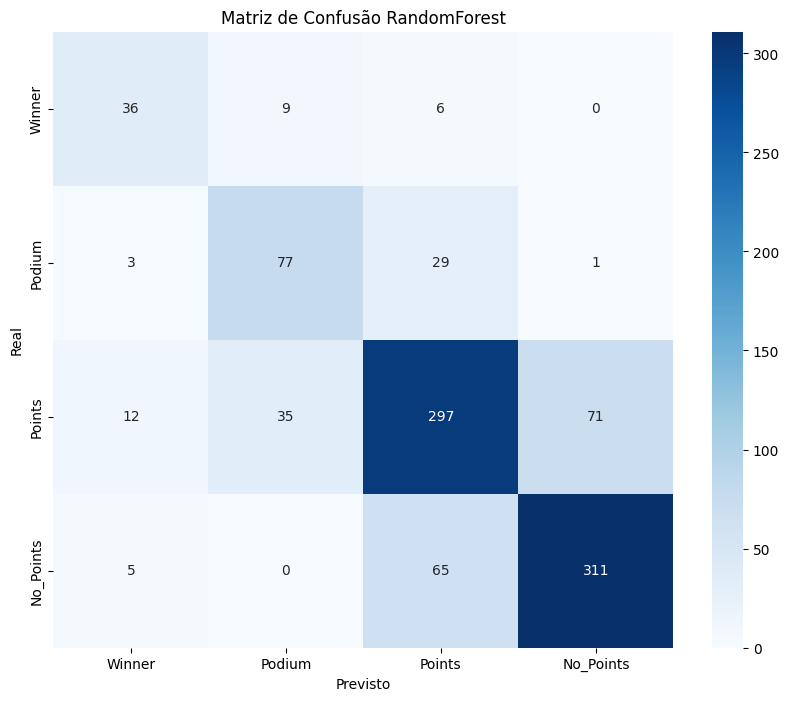

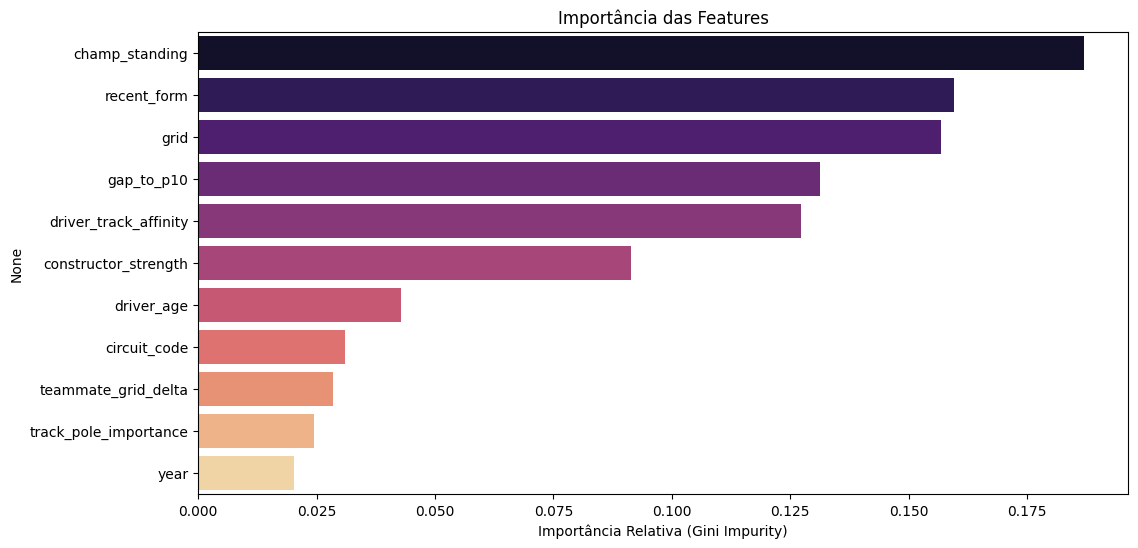

In [46]:
rf_model = RandomForestClassifier(n_estimators=300, max_depth=14, min_samples_leaf=3, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

labels_order = ['Winner', 'Podium', 'Points', 'No_Points']
print(f"Acurácia Global RandomForest: {accuracy_score(y_test, y_pred):.2%}")
print(f"Acurácia Balanceada RandomForest: {balanced_accuracy_score(y_test, y_pred):.2%}")
print("\nRelatório de Classificação:\n")
print(classification_report(y_test, y_pred, labels=labels_order))

cm = confusion_matrix(y_test, y_pred, labels=labels_order)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels_order, yticklabels=labels_order)

plt.title('Matriz de Confusão RandomForest')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

feat_imp = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='magma')
plt.title('Importância das Features')
plt.xlabel('Importância Relativa (Gini Impurity)')
plt.show()

### XGBoost

Acurácia Global XGBoost: 77.43%
Acurácia Balanceada XGBoost: 71.55%

Relatório de Classificação:

              precision    recall  f1-score   support

      Winner       0.66      0.65      0.65        51
      Podium       0.71      0.60      0.65       110
      Points       0.75      0.79      0.77       415
   No_Points       0.84      0.83      0.83       381

    accuracy                           0.77       957
   macro avg       0.74      0.72      0.73       957
weighted avg       0.77      0.77      0.77       957



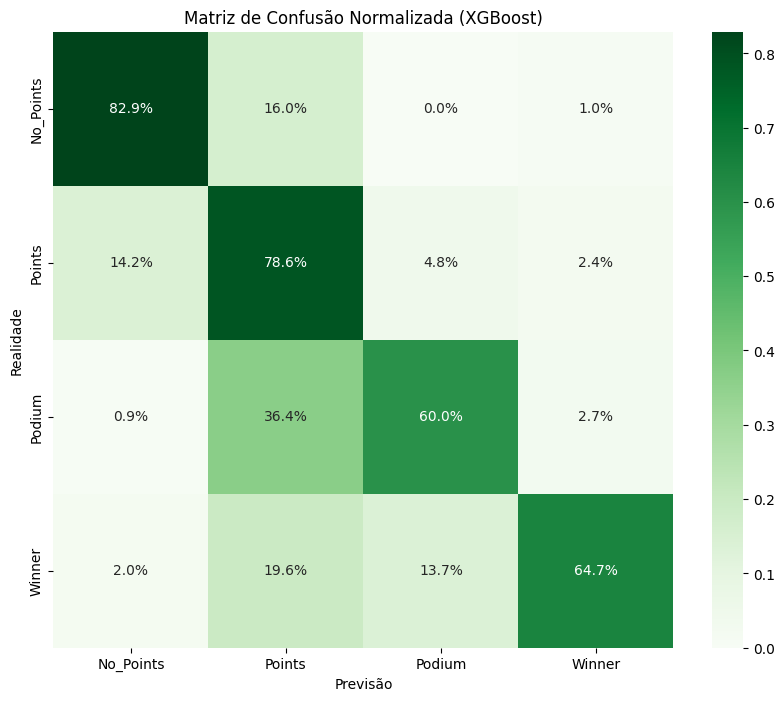

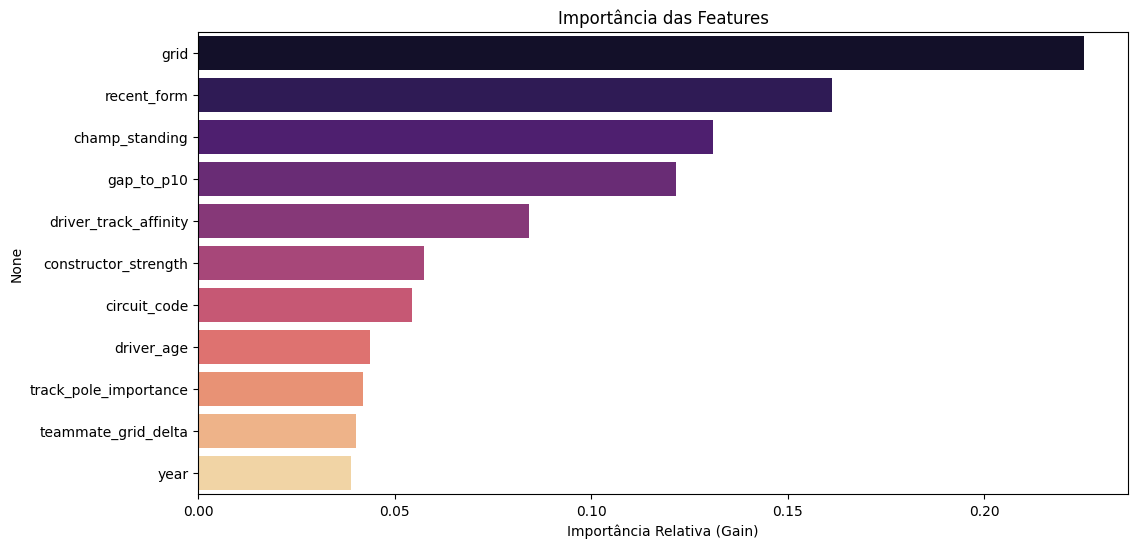

In [47]:
le = LabelEncoder()
class_map = {'No_Points': 0, 'Points': 1, 'Podium': 2, 'Winner': 3}

y_train_num = y_train.map(class_map)
y_test_num = y_test.map(class_map)

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

model = xgb.XGBClassifier(
    n_estimators=600,       
    learning_rate=0.03,     
    max_depth=5,            
    min_child_weight=3,     
    subsample=0.8,          
    colsample_bytree=0.8,   
    objective='multi:softprob',
    num_class=4,
    random_state=42,
    sample_weight=sample_weights,
    n_jobs=-1
)
model.fit(X_train, y_train_num)

y_pred_num = model.predict(X_test)

inv_map = {v: k for k, v in class_map.items()}
y_test_labels = y_test_num.map(inv_map)
y_pred_labels = pd.Series(y_pred_num).map(inv_map)


labels_order = ['Winner', 'Podium', 'Points', 'No_Points']

print(f"Acurácia Global XGBoost: {accuracy_score(y_test_num, y_pred_num):.2%}")
print(f"Acurácia Balanceada XGBoost: {balanced_accuracy_score(y_test_num, y_pred_num):.2%}")
print("\nRelatório de Classificação:\n")
print(classification_report(y_test_labels, y_pred_labels, labels=labels_order))

labels_order_plot = ['No_Points', 'Points', 'Podium', 'Winner']
cm = confusion_matrix(y_test_num, y_pred_num, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.1%', cmap='Greens', 
            xticklabels=labels_order_plot, yticklabels=labels_order_plot)
plt.title('Matriz de Confusão Normalizada (XGBoost)')
plt.ylabel('Realidade')
plt.xlabel('Previsão')
plt.show()

feat_imp = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='magma')
plt.title('Importância das Features')
plt.xlabel('Importância Relativa (Gain)')
plt.show()

# Resultados e Conclusão

O modelo **Random Forest** demonstrou uma performance consistente, alcançando uma **Acurácia Global de 75.34%** e, mais importante, uma **Acurácia Balanceada de 73.45%**. Isso indica que o modelo conseguiu superar o desbalanceamento natural do dataset, não se limitando a apenas prever a classe majoritária (*No_Points*).

### Destaques da Avaliação:
1.  **Alta Sensibilidade para Vitórias:** O modelo obteve um *Recall* de **0.71** para a classe `Winner`. De 51 vencedores reais no conjunto de teste, o modelo identificou corretamente 36. Isso valida a capacidade do algoritmo em capturar os padrões sutis que diferenciam um vencedor de um mero pódio.
2.  **Erros Adjacentes:** A Matriz de Confusão revela que a maioria dos erros é "gradual" ou adjacente. Por exemplo, quando o modelo erra um `Winner`, ele geralmente prevê `Podium` (9 casos), e raramente `No_Points` (apenas 5 casos). O modelo entende a hierarquia de performance.
3.  **Validação da Feature Engineering:**
    * A predominância de `champ_standing` (1º) e `recent_form` (2º) na importância das features confirma que o **contexto da temporada** é mais preditivo do que a posição de largada isolada (`grid`, que ficou em 3º).
    * A feature criada manualmente, `gap_to_p10`, apareceu como a **4ª mais importante**, superando variáveis tradicionais como idade e afinidade com a pista. Isso comprova que a diferença de tempo real na qualificação é um indicador crítico de desempenho no meio do pelotão.

O modelo **XGBoost** apresentou a melhor **Acurácia Global do projeto (77.43%)**, demonstrando uma capacidade superior de generalização, embora tenha ficado com uma Acurácia Balanceada (71.55%) menor em comparação ao Random Forest.

### Destaques da Avaliação:
1.  **Mudança na Hierarquia de Decisão:** Ao contrário do Random Forest, que priorizou o contexto da temporada, o XGBoost identificou a posição de largada (`grid`) como a feature mais determinante, seguida por `recent_form`. Isso sugere que o modelo se comporta de forma mais "pragmática", confiando mais na realidade imediata da pista do que no histórico do campeonato.
2.  **Conservadorismo nas Classes Intermediárias:** A Matriz de Confusão Normalizada revela que o modelo é excelente em prever quem **não pontua** (82.9% de acerto). No entanto, há uma confusão relevante na classe `Podium`: em 36.4% dos casos, ele previu que um piloto de pódio terminaria apenas na zona de pontos. O modelo tende a ser conservador em suas apostas.
3.  **Performance na Classe Winner:** O modelo manteve uma performance sólida para identificar vencedores (64.7% de acerto), mas com uma precisão um pouco maior que o Random Forest (0.66 vs 0.64), indicando menos falsos positivos para a vitória.